In [4]:
import pandas as pd

email_data = pd.read_csv('C:/Users/User/OneDrive - Asia Pacific University/APU Final Year Project/FYP Email Project Documents/Email Dataset Python/Model Building/Prioritization/test_cleaned_priority_email_dataset_machine_learning_model.csv')

In [5]:
email_data['Combined_Text'] = email_data['Cleaned_Subject'].fillna('') + ' ' + email_data['Cleaned_Message'].fillna('')

In [6]:
email_data.columns

Index(['Email ID', 'From', 'To', 'Date & Time', 'Subject', 'Message',
       'Priority', 'Cleaned_Message', 'Cleaned_Subject', 'Combined_Text'],
      dtype='object')

In [7]:
email_data['Priority'].value_counts()

Priority
Medium    48202
Low       41158
High      31883
Name: count, dtype: int64

In [8]:
min_class_size = email_data['Priority'].value_counts().min()
balanced_email_data = email_data.groupby('Priority').apply(lambda x: x.sample(min_class_size, random_state=42)).reset_index(drop=True)

print(balanced_email_data['Priority'].value_counts())

Priority
High      31883
Low       31883
Medium    31883
Name: count, dtype: int64


C:\Users\User\AppData\Local\Temp\ipykernel_19556\1101715008.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_email_data = email_data.groupby('Priority').apply(lambda x: x.sample(min_class_size, random_state=42)).reset_index(drop=True)


In [9]:

def partial_undersample(df, target_col='Priority', cap=31883):
    balanced_list = []
    for label, group in df.groupby(target_col):
        if len(group) > cap:
            sampled = group.sample(n=cap, random_state=42)
        else:
            sampled = group
        balanced_list.append(sampled)
    return pd.concat(balanced_list).reset_index(drop=True)

# Apply the undersampling
partially_balanced_email_data = partial_undersample(email_data, target_col='Priority', cap=30506)

# Check the new distribution
print(partially_balanced_email_data['Priority'].value_counts())

Priority
High      30506
Low       30506
Medium    30506
Name: count, dtype: int64


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sentence_transformers import SentenceTransformer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# === Split into Train and Test
X = partially_balanced_email_data['Combined_Text']
y = partially_balanced_email_data['Priority']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# === Encode Labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# === BERT Embeddings
embedder = SentenceTransformer("all-MiniLM-L6-v2")
X_train_embed = embedder.encode(X_train.tolist(), show_progress_bar=True)
X_test_embed = embedder.encode(X_test.tolist(), show_progress_bar=True)

Batches:   0%|          | 0/2288 [00:00<?, ?it/s]

Batches:   0%|          | 0/572 [00:00<?, ?it/s]

In [11]:
import joblib
import os
import numpy as np

# === Define your save directory ===
save_dir = r"C:/Users/User/OneDrive - Asia Pacific University/APU Final Year Project/FYP Email Project Documents/Email Dataset Python/Model Building/Prioritization/Test Bert Results"

# === Create the directory if it doesn't exist ===
os.makedirs(save_dir, exist_ok=True)

np.save(os.path.join(save_dir, "X_train_embed.npy"), X_train_embed)
np.save(os.path.join(save_dir, "X_test_embed.npy"), X_test_embed)
np.save(os.path.join(save_dir, "y_test_encoded.npy"), y_test_encoded)
np.save(os.path.join(save_dir, "y_train_encoded.npy"), y_train_encoded)

# SVM

In [ ]:
# === SVM Model
svm_model = SVC(kernel='linear', class_weight='balanced', probability=True, random_state=42)
svm_model.fit(X_train_embed, y_train_encoded)

# === Predictions
y_pred = svm_model.predict(X_test_embed)

# === Evaluation
print("✅ Accuracy:", accuracy_score(y_test_encoded, y_pred))
print("📊 Classification Report:")
print(classification_report(y_test_encoded, y_pred, target_names=label_encoder.classes_))

# === Confusion Matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='PuBu',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix - BERT + SVM (Partial Undersampling)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

In [12]:
import joblib
import os
import numpy as np

save_dir = r"C:/Users/User/OneDrive - Asia Pacific University/APU Final Year Project/FYP Email Project Documents/Email Dataset Python/Model Building/Prioritization/Test Bert Results"

os.makedirs(save_dir, exist_ok=True)

joblib.dump(svm_model, os.path.join(save_dir, 'bert_svm_model.joblib')) 

['C:/Users/User/OneDrive - Asia Pacific University/APU Final Year Project/FYP Email Project Documents/Email Dataset Python/Model Building/Prioritization/Test Bert Results\\bert_svm_model.joblib']

# Linear Regression

🧠 Training Logistic Regression...


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


✅ Accuracy (BERT + Logistic Regression): 0.9912041083916084

📊 Classification Report:
              precision    recall  f1-score   support

        High       1.00      1.00      1.00      6101
         Low       0.99      0.99      0.99      6101
      Medium       0.99      0.99      0.99      6102

    accuracy                           0.99     18304
   macro avg       0.99      0.99      0.99     18304
weighted avg       0.99      0.99      0.99     18304



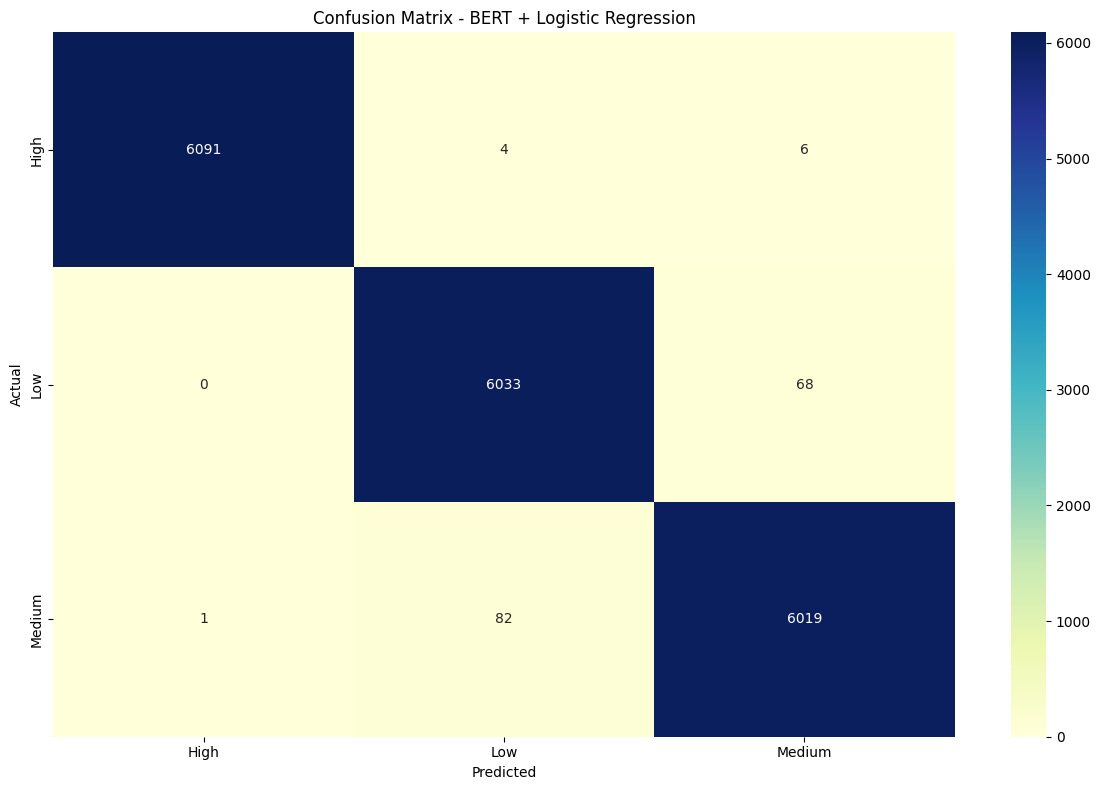

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# === Step 5: Train Logistic Regression model
print("🧠 Training Logistic Regression...")
lr_model = LogisticRegression(
    solver='liblinear',
    multi_class='ovr',
    class_weight='balanced',
    max_iter=1000,
    random_state=42
)
lr_model.fit(X_train_embed, y_train_encoded)

# === Step 6: Evaluate the model
y_pred = lr_model.predict(X_test_embed)

print("✅ Accuracy (BERT + Logistic Regression):", accuracy_score(y_test_encoded, y_pred))
print("\n📊 Classification Report:")
print(classification_report(y_test_encoded, y_pred, target_names=label_encoder.classes_))

# === Step 7: Plot confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix - BERT + Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

In [ ]:
import joblib
import os
import numpy as np

save_dir = r"C:/Users/User/OneDrive - Asia Pacific University/APU Final Year Project/FYP Email Project Documents/Email Dataset Python/Model Building/Prioritization/Test Bert Results"

os.makedirs(save_dir, exist_ok=True)

joblib.dump(lr_model, os.path.join(save_dir, 'bert_lr_model.joblib')) 

# Random Forest

🌲 Training Random Forest...
✅ Accuracy (BERT + Random Forest): 0.9922421328671329

📊 Classification Report:
              precision    recall  f1-score   support

        High       1.00      1.00      1.00      6101
         Low       0.98      0.99      0.99      6101
      Medium       0.99      0.98      0.99      6102

    accuracy                           0.99     18304
   macro avg       0.99      0.99      0.99     18304
weighted avg       0.99      0.99      0.99     18304



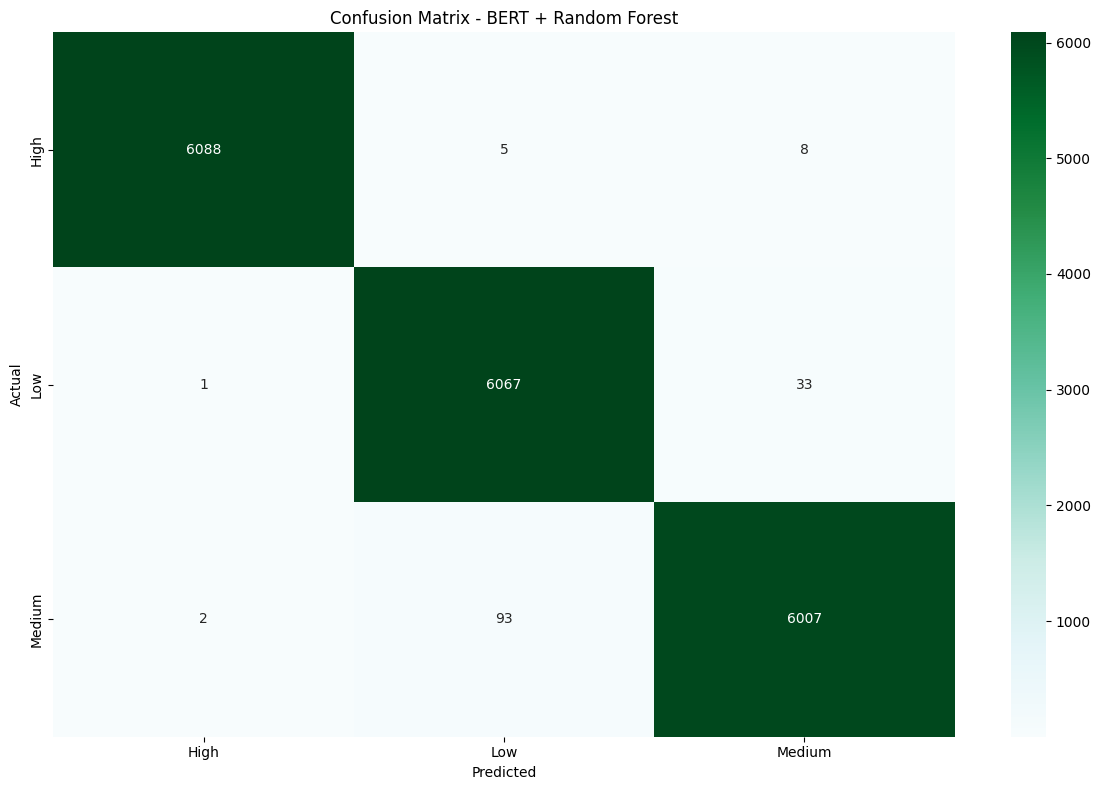

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# === Step 5: Train Random Forest classifier
print("🌲 Training Random Forest...")
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=30,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train_embed, y_train_encoded)

# === Step 6: Evaluate
y_pred = rf_model.predict(X_test_embed)

print("✅ Accuracy (BERT + Random Forest):", accuracy_score(y_test_encoded, y_pred))
print("\n📊 Classification Report:")
print(classification_report(y_test_encoded, y_pred, target_names=label_encoder.classes_))

# === Step 7: Confusion Matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='BuGn',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix - BERT + Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

In [16]:
import joblib
import os
import numpy as np

save_dir = r"C:/Users/User/OneDrive - Asia Pacific University/APU Final Year Project/FYP Email Project Documents/Email Dataset Python/Model Building/Prioritization/Test Bert Results"

os.makedirs(save_dir, exist_ok=True)

joblib.dump(rf_model, os.path.join(save_dir, 'bert_rf_model.joblib')) 

['C:/Users/User/OneDrive - Asia Pacific University/APU Final Year Project/FYP Email Project Documents/Email Dataset Python/Model Building/Prioritization/Test Bert Results\\bert_rf_model.joblib']

# XG Boost

🚀 Training XGBoost model...


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\xgboost\core.py:158: UserWarning: [22:56:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ Accuracy (BERT + XGBoost): 0.9929523601398601

📊 Classification Report:
              precision    recall  f1-score   support

        High       1.00      1.00      1.00      6101
         Low       0.99      0.99      0.99      6101
      Medium       0.99      0.99      0.99      6102

    accuracy                           0.99     18304
   macro avg       0.99      0.99      0.99     18304
weighted avg       0.99      0.99      0.99     18304



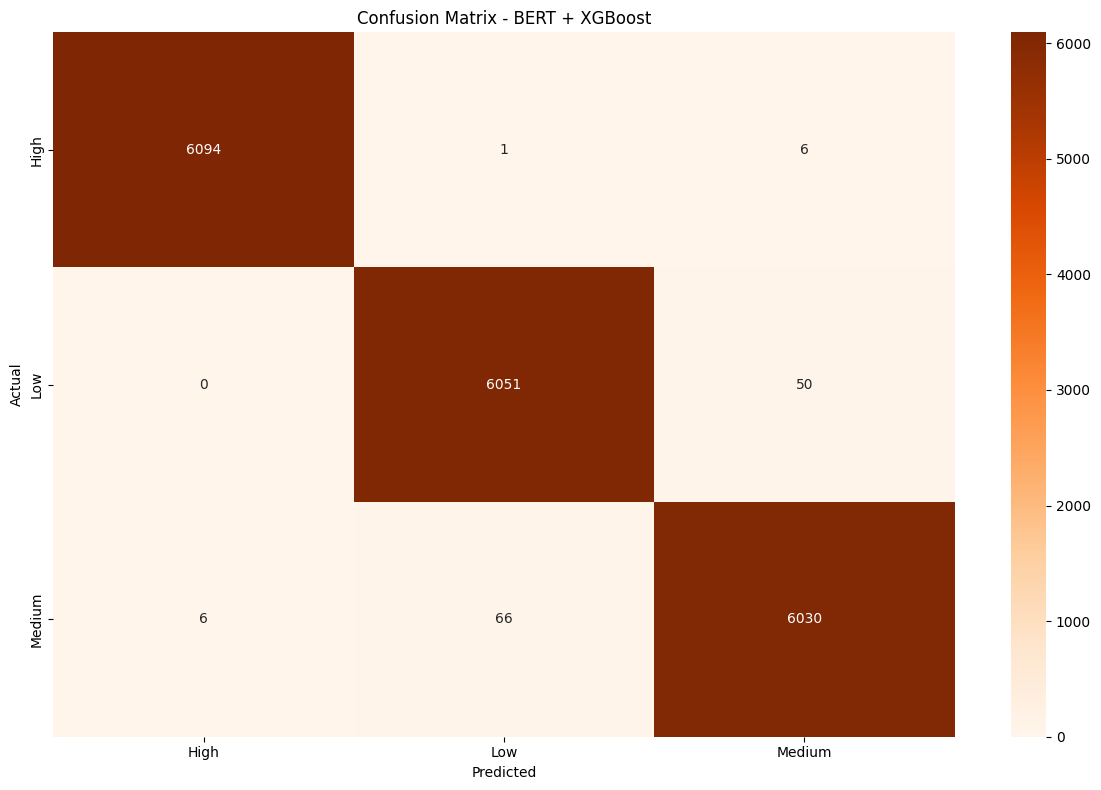

In [17]:
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# === Step 6: Train XGBoost model
print("🚀 Training XGBoost model...")
xgb_model = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=len(label_encoder.classes_),
    eval_metric='mlogloss',
    n_estimators=250,
    learning_rate=0.1,
    max_depth=10,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    tree_method='hist',  # or 'gpu_hist' if using GPU
    random_state=42
)

xgb_model.fit(X_train_embed, y_train_encoded)

# === Step 7: Predictions
y_pred = xgb_model.predict(X_test_embed)

# === Step 8: Evaluation
print("✅ Accuracy (BERT + XGBoost):", accuracy_score(y_test_encoded, y_pred))
print("\n📊 Classification Report:")
print(classification_report(y_test_encoded, y_pred, target_names=label_encoder.classes_))

# === Step 9: Confusion Matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Oranges',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix - BERT + XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

In [18]:
import joblib
import os
import numpy as np

save_dir = r"C:/Users/User/OneDrive - Asia Pacific University/APU Final Year Project/FYP Email Project Documents/Email Dataset Python/Model Building/Prioritization/Test Bert Results"

os.makedirs(save_dir, exist_ok=True)

joblib.dump(xgb_model, os.path.join(save_dir, 'bert_xgb_model.joblib')) 

['C:/Users/User/OneDrive - Asia Pacific University/APU Final Year Project/FYP Email Project Documents/Email Dataset Python/Model Building/Prioritization/Test Bert Results\\bert_xgb_model.joblib']

# Naive Bayes

✅ Accuracy (BERT + GaussianNB): 0.8538570804195804

📊 Classification Report:
              precision    recall  f1-score   support

        High       0.91      0.90      0.91      6101
         Low       0.87      0.81      0.84      6101
      Medium       0.79      0.85      0.82      6102

    accuracy                           0.85     18304
   macro avg       0.86      0.85      0.85     18304
weighted avg       0.86      0.85      0.85     18304



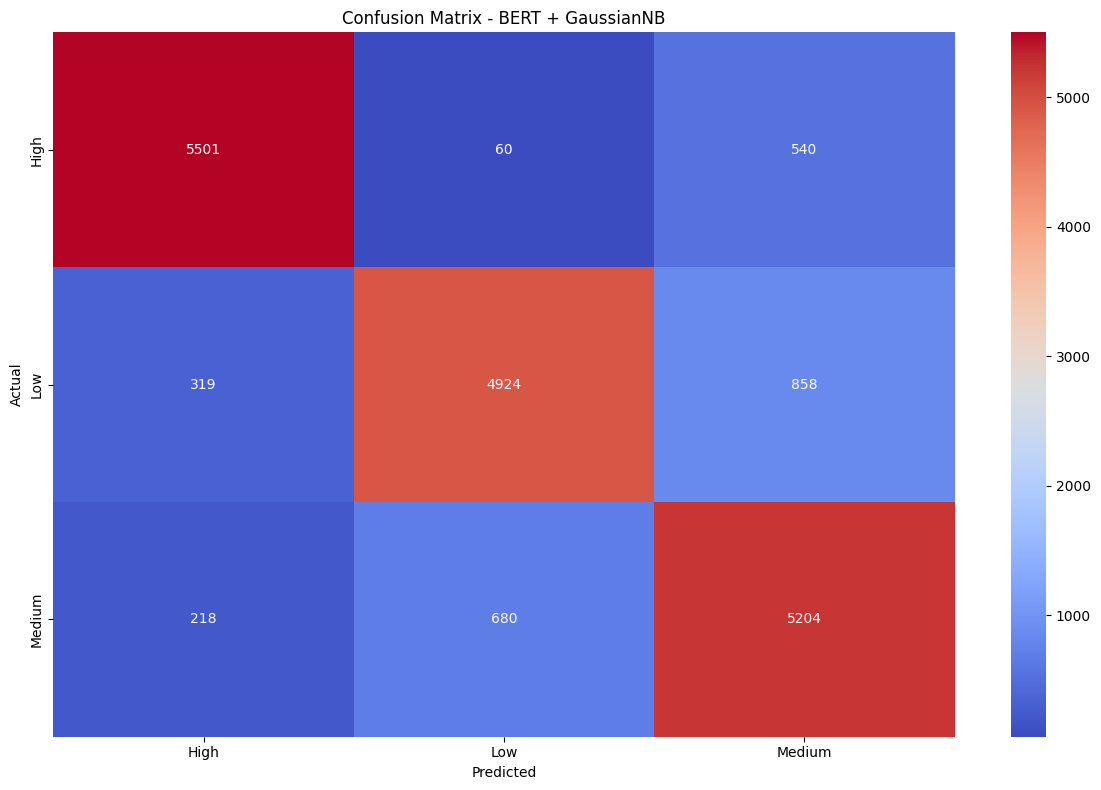

In [18]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# === Step 1: Initialize and train
nb_model = GaussianNB()
nb_model.fit(X_train_embed, y_train_encoded)

# === Step 2: Predict
y_pred = nb_model.predict(X_test_embed)

# === Step 3: Evaluate
print("✅ Accuracy (BERT + GaussianNB):", accuracy_score(y_test_encoded, y_pred))
print("\n📊 Classification Report:")
print(classification_report(y_test_encoded, y_pred, target_names=label_encoder.classes_))

# === Step 4: Confusion Matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='coolwarm',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix - BERT + GaussianNB")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

In [20]:
import joblib
import os
import numpy as np

# === Define your save directory ===
save_dir = r"C:/Users/User/OneDrive - Asia Pacific University/APU Final Year Project/FYP Email Project Documents/Email Dataset Python/Model Building/Prioritization/Test Bert Results"

# === Create the directory if it doesn't exist ===
os.makedirs(save_dir, exist_ok=True)

# === Save individual models ===
joblib.dump(nb_model, os.path.join(save_dir, 'bert_nb_model.joblib'))        # Gaussian Naive Bayes

['C:/Users/User/OneDrive - Asia Pacific University/APU Final Year Project/FYP Email Project Documents/Email Dataset Python/Model Building/Prioritization/Test Bert Results\\bert_nb_model.joblib']

# Hybrid Model

🚀 Training Hybrid Voting Classifier...
✅ Accuracy (BERT + Hybrid Ensemble): 0.9930616258741258

📊 Classification Report:
              precision    recall  f1-score   support

        High       1.00      1.00      1.00      6101
         Low       0.99      0.99      0.99      6101
      Medium       0.99      0.99      0.99      6102

    accuracy                           0.99     18304
   macro avg       0.99      0.99      0.99     18304
weighted avg       0.99      0.99      0.99     18304



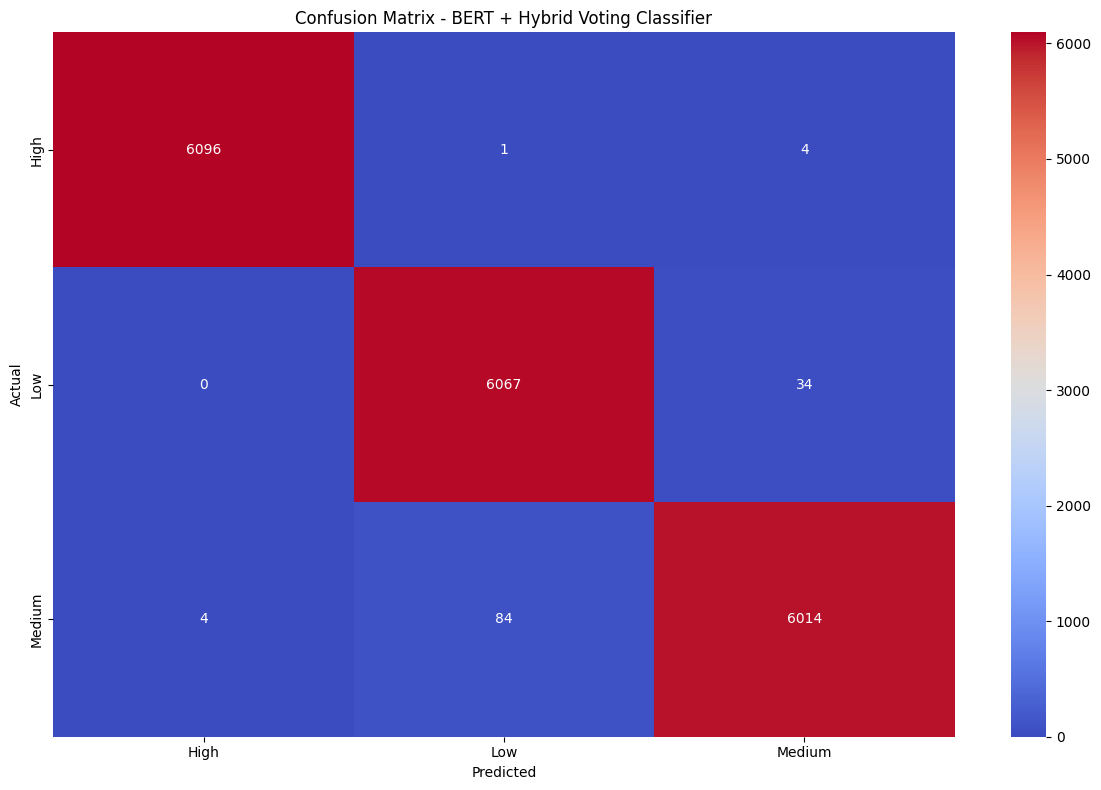

In [19]:
from sklearn.ensemble import VotingClassifier

voting_model = VotingClassifier(
    estimators=[
        ('svm', svm_model),
        ('lr', lr_model),
        ('rf', rf_model),
        ('xgb', xgb_model)
    ],
    voting='soft',         # Soft = probability averaging
    weights=[2, 2, 1, 3],   # Weighted voting (you can tune this)
    n_jobs=-1
)

# === Step 4: Fit hybrid model
print("🚀 Training Hybrid Voting Classifier...")
voting_model.fit(X_train_embed, y_train_encoded)

# === Step 5: Predict
y_pred = voting_model.predict(X_test_embed)

# === Step 6: Evaluate
print("✅ Accuracy (BERT + Hybrid Ensemble):", accuracy_score(y_test_encoded, y_pred))
print("\n📊 Classification Report:")
print(classification_report(y_test_encoded, y_pred, target_names=label_encoder.classes_))

# === Step 7: Confusion Matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='coolwarm',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix - BERT + Hybrid Voting Classifier")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

In [22]:
import joblib
import os
import numpy as np

# === Define your save directory ===
save_dir = r"C:/Users/User/OneDrive - Asia Pacific University/APU Final Year Project/FYP Email Project Documents/Email Dataset Python/Model Building/Prioritization/Test Bert Results"

# === Create the directory if it doesn't exist ===
os.makedirs(save_dir, exist_ok=True)

# === Save individual models ===
joblib.dump(voting_model, os.path.join(save_dir, 'bert_hybrid_soft_model.joblib'))  # Hybrid Soft Voting


['C:/Users/User/OneDrive - Asia Pacific University/APU Final Year Project/FYP Email Project Documents/Email Dataset Python/Model Building/Prioritization/Test Bert Results\\bert_hybrid_soft_model.joblib']

# Save Model

In [20]:
import joblib
import os
import numpy as np

# === Define your save directory ===
save_dir = r"C:/Users/User/OneDrive - Asia Pacific University/APU Final Year Project/FYP Email Project Documents/Email Dataset Python/Model Building/Prioritization/Test Bert Results"

# === Create the directory if it doesn't exist ===
os.makedirs(save_dir, exist_ok=True)

# === Save individual models ===
joblib.dump(lr_model, os.path.join(save_dir, 'bert_lr_model.joblib'))        # Logistic Regression
joblib.dump(rf_model, os.path.join(save_dir, 'bert_rf_model.joblib'))        # Random Forest
joblib.dump(svm_model, os.path.join(save_dir, 'bert_svm_model.joblib'))      # SVM
joblib.dump(xgb_model, os.path.join(save_dir, 'bert_xgb_model.joblib'))      # XGBoost
joblib.dump(nb_model, os.path.join(save_dir, 'bert_nb_model.joblib'))        # Gaussian Naive Bayes
joblib.dump(voting_model, os.path.join(save_dir, 'bert_hybrid_soft_model.joblib'))  # Hybrid Soft Voting

# === Save encoder and embedder ===
joblib.dump(label_encoder, os.path.join(save_dir, 'label_encoder.joblib'))

# Save BERT embedder model (to a subfolder)
embedder.save(os.path.join(save_dir, 'bert_embedder_model'))

# Model Comparison

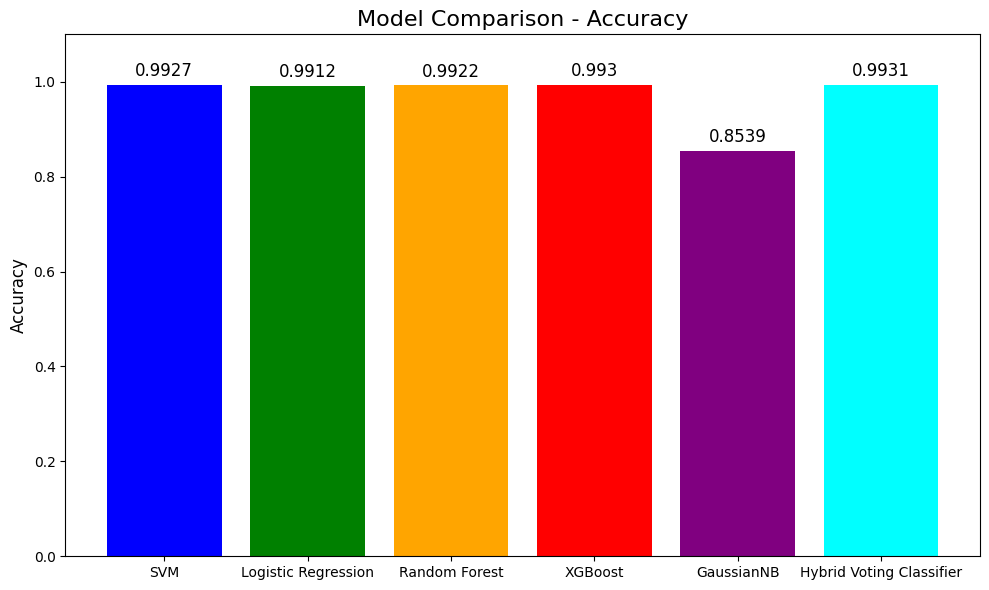

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
import xgboost as xgb
from sklearn.naive_bayes import GaussianNB

# === Define the function to evaluate model accuracy ===
def evaluate_model(model, X_test_embed, y_test_encoded):
    # Make predictions
    y_pred = model.predict(X_test_embed)
    
    # Evaluate accuracy
    accuracy = accuracy_score(y_test_encoded, y_pred)
    
    return accuracy

# === Step 1: Evaluate all models ===
# List of models to compare
models = {
    "SVM": svm_model,
    "Logistic Regression": lr_model,
    "Random Forest": rf_model,
    "XGBoost": xgb_model,
    "GaussianNB": nb_model,
    "Hybrid Voting Classifier": voting_model
}

# Collect accuracies
accuracies = {name: evaluate_model(model, X_test_embed, y_test_encoded) for name, model in models.items()}

# === Step 2: Create a bar chart to compare the models ===
model_names = list(accuracies.keys())
model_accuracies = list(accuracies.values())

# Plotting the comparison bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, model_accuracies, color=['blue', 'green', 'orange', 'red', 'purple', 'cyan'])

# Add accuracy labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, round(yval, 4), ha='center', va='bottom', fontsize=12)

# Adding titles and labels
plt.title("Model Comparison - Accuracy", fontsize=16)
plt.ylabel("Accuracy", fontsize=12)
plt.ylim(0, 1.1)  # Set y-axis limits to slightly exceed 1.0 for better visualization
plt.tight_layout()

# Show the plot
plt.show()

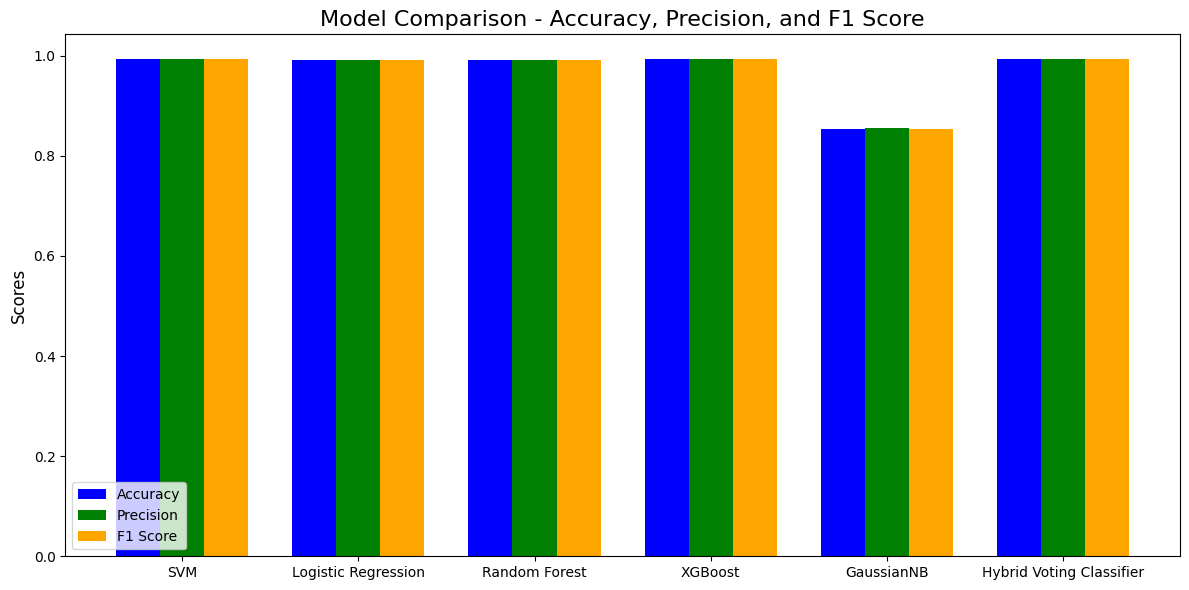

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, f1_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
import xgboost as xgb
from sklearn.naive_bayes import GaussianNB

# === Define the function to evaluate model metrics ===
def evaluate_model(model, X_test_embed, y_test_encoded):
    # Make predictions
    y_pred = model.predict(X_test_embed)
    
    # Calculate accuracy, precision, and F1 score
    accuracy = accuracy_score(y_test_encoded, y_pred)
    precision = precision_score(y_test_encoded, y_pred, average='weighted')  # weighted for multi-class
    f1 = f1_score(y_test_encoded, y_pred, average='weighted')  # weighted for multi-class
    
    return accuracy, precision, f1

# === Step 1: Evaluate all models and store metrics ===
# List of models to compare
models = {
    "SVM": svm_model,
    "Logistic Regression": lr_model,
    "Random Forest": rf_model,
    "XGBoost": xgb_model,
    "GaussianNB": nb_model,
    "Hybrid Voting Classifier": voting_model
}

# Collect metrics for each model
metrics = {name: evaluate_model(model, X_test_embed, y_test_encoded) for name, model in models.items()}

# === Step 2: Prepare data for plotting ===
model_names = list(metrics.keys())
accuracies = [metrics[name][0] for name in model_names]
precisions = [metrics[name][1] for name in model_names]
f1_scores = [metrics[name][2] for name in model_names]

# === Step 3: Plotting vertical bar chart for Accuracy, Precision, and F1 Score ===
x = range(len(model_names))  # Position of bars

# Set bar width
width = 0.25

plt.figure(figsize=(12, 6))

# Plot the bars for each metric
bars1 = plt.bar(x, accuracies, width=width, label='Accuracy', color='blue')
bars2 = plt.bar([p + width for p in x], precisions, width=width, label='Precision', color='green')
bars3 = plt.bar([p + width * 2 for p in x], f1_scores, width=width, label='F1 Score', color='orange')

# Add metric labels inside each bar horizontally
for bar in bars1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, f'{round(yval, 4)}', ha='center', va='bottom', fontsize=12, color='white')

for bar in bars2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, f'{round(yval, 4)}', ha='center', va='bottom', fontsize=12, color='white')

for bar in bars3:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, f'{round(yval, 4)}', ha='center', va='bottom', fontsize=12, color='white')

# Add labels and title
plt.title("Model Comparison - Accuracy, Precision, and F1 Score", fontsize=16)
plt.ylabel("Scores", fontsize=12)
plt.xticks([p + width for p in x], model_names)  # Set the model names on x-axis
plt.legend()

# Adjust layout for better fit
plt.tight_layout()

# Show the plot
plt.show()

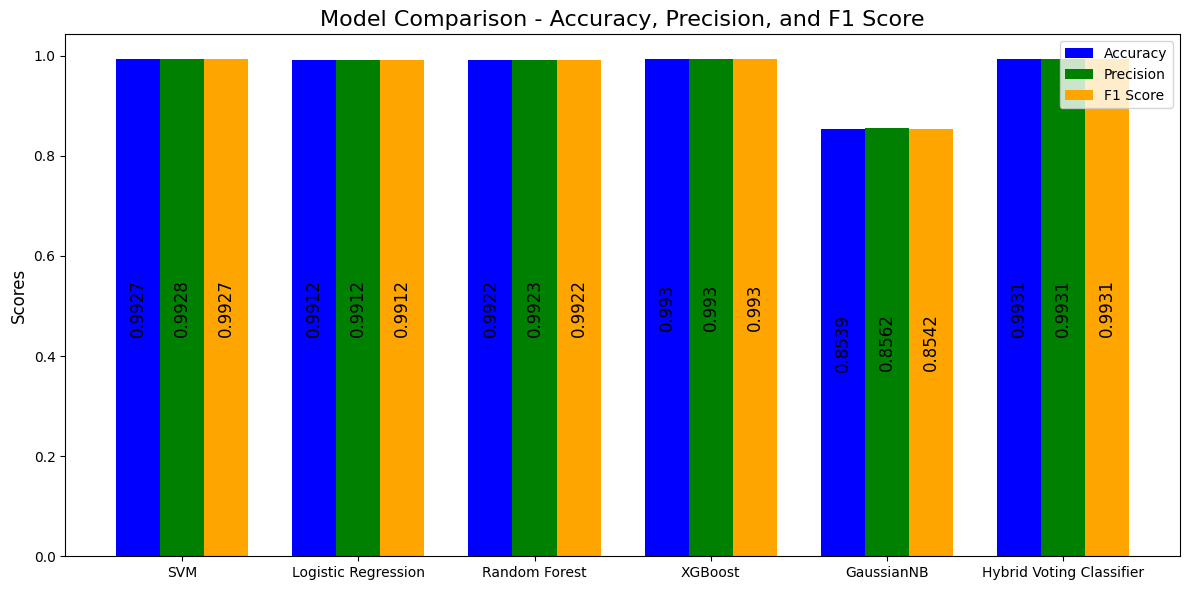

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, f1_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
import xgboost as xgb
from sklearn.naive_bayes import GaussianNB

# === Define the function to evaluate model metrics ===
def evaluate_model(model, X_test_embed, y_test_encoded):
    # Make predictions
    y_pred = model.predict(X_test_embed)
    
    # Calculate accuracy, precision, and F1 score
    accuracy = accuracy_score(y_test_encoded, y_pred)
    precision = precision_score(y_test_encoded, y_pred, average='weighted')  # weighted for multi-class
    f1 = f1_score(y_test_encoded, y_pred, average='weighted')  # weighted for multi-class
    
    return accuracy, precision, f1

# === Step 1: Evaluate all models and store metrics ===
# List of models to compare
models = {
    "SVM": svm_model,
    "Logistic Regression": lr_model,
    "Random Forest": rf_model,
    "XGBoost": xgb_model,
    "GaussianNB": nb_model,
    "Hybrid Voting Classifier": voting_model
}

# Collect metrics for each model
metrics = {name: evaluate_model(model, X_test_embed, y_test_encoded) for name, model in models.items()}

# === Step 2: Prepare data for plotting ===
model_names = list(metrics.keys())
accuracies = [metrics[name][0] for name in model_names]
precisions = [metrics[name][1] for name in model_names]
f1_scores = [metrics[name][2] for name in model_names]

# === Step 3: Plotting vertical bar chart for Accuracy, Precision, and F1 Score ===
x = range(len(model_names))  # Position of bars

# Set bar width
width = 0.25

plt.figure(figsize=(12, 6))

# Plot the bars for each metric
bars1 = plt.bar(x, accuracies, width=width, label='Accuracy', color='blue')
bars2 = plt.bar([p + width for p in x], precisions, width=width, label='Precision', color='green')
bars3 = plt.bar([p + width * 2 for p in x], f1_scores, width=width, label='F1 Score', color='orange')

# Add metric labels inside each bar, vertically centered
for bar in bars1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval / 2, f'{round(yval, 4)}', ha='center', va='center', fontsize=12, rotation=90)

for bar in bars2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval / 2, f'{round(yval, 4)}', ha='center', va='center', fontsize=12, rotation=90)

for bar in bars3:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval / 2, f'{round(yval, 4)}', ha='center', va='center', fontsize=12, rotation=90)

# Add labels and title
plt.title("Model Comparison - Accuracy, Precision, and F1 Score", fontsize=16)
plt.ylabel("Scores", fontsize=12)
plt.xticks([p + width for p in x], model_names)  # Set the model names on x-axis
plt.legend()

# Adjust layout for better fit
plt.tight_layout()

# Show the plot
plt.show()

# Test Data

Batches:   0%|          | 0/69 [00:00<?, ?it/s]

✅ Accuracy: 0.7038548752834467

📊 Classification Report:

              precision    recall  f1-score   support

        High       0.26      0.88      0.41        16
         Low       0.90      0.75      0.82      1890
      Medium       0.22      0.43      0.29       299

    accuracy                           0.70      2205
   macro avg       0.46      0.68      0.50      2205
weighted avg       0.80      0.70      0.74      2205



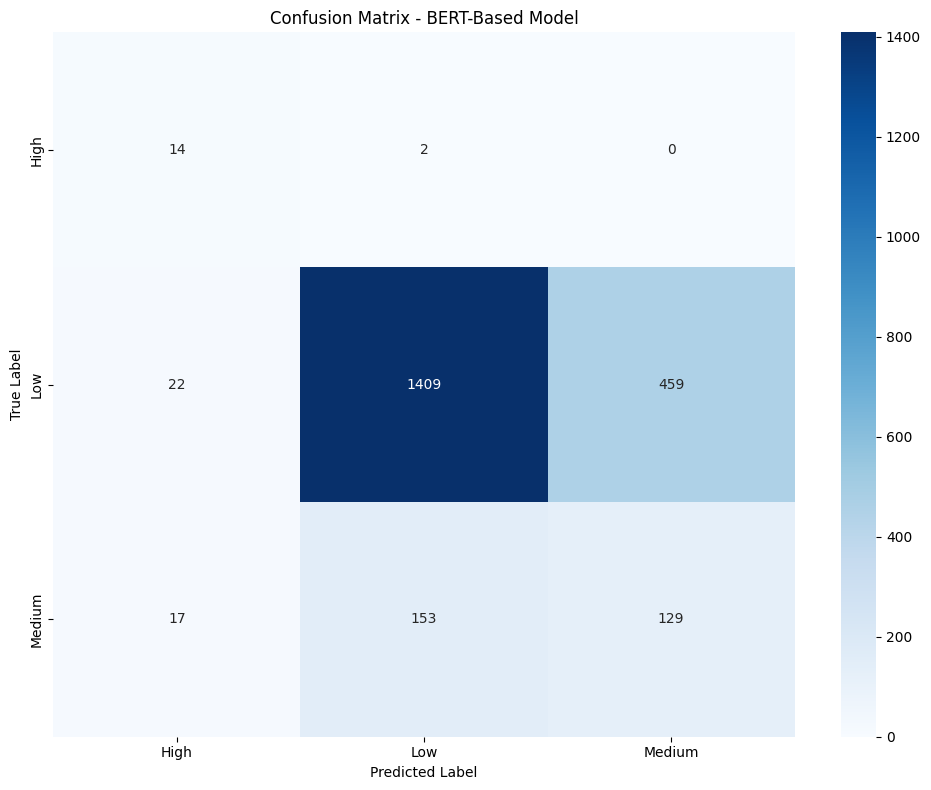

In [2]:
import pandas as pd
import joblib
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import os

# === Step 1: Load test data ===
test_data_path = r"C:/Users/User/OneDrive - Asia Pacific University/APU Final Year Project/FYP Email Project Documents/Email Dataset Python/Model Building/Prioritization/emails_202504202357.csv"
df_test = pd.read_csv(test_data_path)

# === Step 2: Load saved model components ===
save_dir = r"C:/Users/User/OneDrive - Asia Pacific University/APU Final Year Project/FYP Email Project Documents/Email Dataset Python/Model Building/Prioritization/Test Bert Results"

model_path = os.path.join(save_dir, 'bert_hybrid_soft_model.joblib')  # <-- Change this to 'bert_lr_model.joblib', etc.
encoder_path = os.path.join(save_dir, 'label_encoder.joblib')
embedder_path = os.path.join(save_dir, 'bert_embedder_model')

model = joblib.load(model_path)
label_encoder = joblib.load(encoder_path)
embedder = SentenceTransformer(embedder_path)

# === Step 3: Preprocess & Embed test data ===
df_test['Combined_Text'] = df_test['Subject'].fillna('') + ' ' + df_test['Message'].fillna('')
X_test_text = df_test['Combined_Text'].astype(str).tolist()
X_test_embed = embedder.encode(X_test_text, show_progress_bar=True)

# === Step 4: Encode true labels if available ===
if 'True_Priority' in df_test.columns:
    y_true = label_encoder.transform(df_test['True_Priority'])

# === Step 5: Predict
y_pred = model.predict(X_test_embed)
df_test['Predicted_Label'] = y_pred
df_test['Predicted_Priority'] = label_encoder.inverse_transform(y_pred)

# === Step 6: Evaluation
if 'True_Priority' in df_test.columns:
    print("✅ Accuracy:", accuracy_score(y_true, y_pred))

    unique_classes = np.unique(y_true)
    target_names = label_encoder.inverse_transform(unique_classes)

    print("\n📊 Classification Report:\n")
    print(classification_report(y_true, y_pred, labels=unique_classes, target_names=target_names))

    # === Step 7: Confusion Matrix
    conf_matrix = confusion_matrix(y_true, y_pred, labels=unique_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d",
                xticklabels=target_names, yticklabels=target_names, cmap="Blues")
    plt.title("Confusion Matrix - BERT-Based Model")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.show()

# Additional

# Real Sample Emails

Batches:   0%|          | 0/126 [00:00<?, ?it/s]


🚀 Evaluating: SVM
✅ Accuracy: 0.8777
              precision    recall  f1-score   support

        High       0.64      0.80      0.71       157
         Low       0.90      0.96      0.93      2976
      Medium       0.86      0.62      0.72       873

    accuracy                           0.88      4006
   macro avg       0.80      0.79      0.79      4006
weighted avg       0.88      0.88      0.87      4006



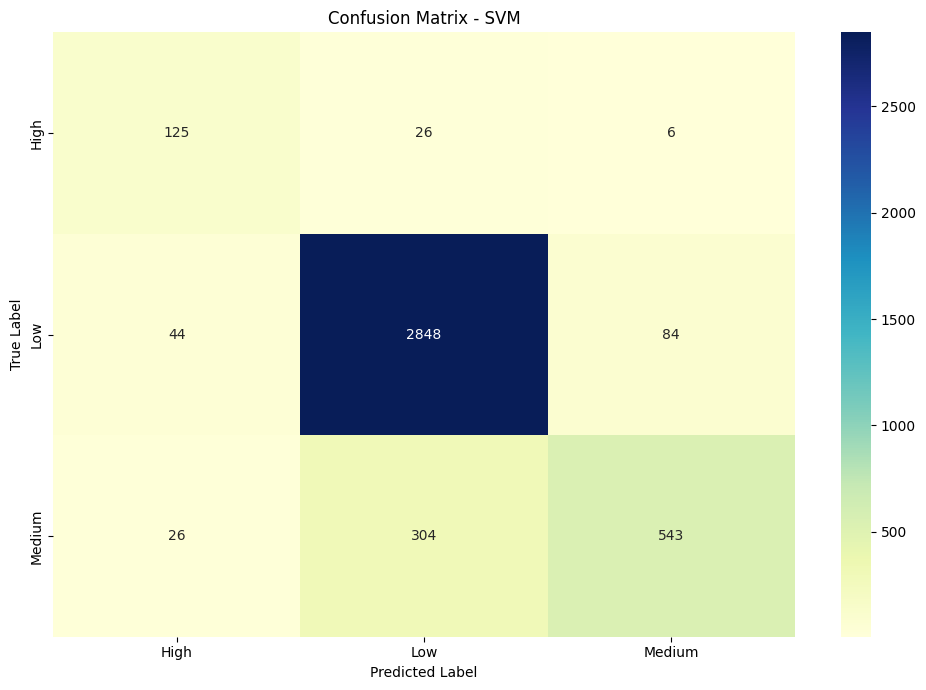


🚀 Evaluating: Logistic Regression
✅ Accuracy: 0.9558
              precision    recall  f1-score   support

        High       0.77      0.90      0.83       157
         Low       0.96      0.99      0.97      2976
      Medium       1.00      0.85      0.92       873

    accuracy                           0.96      4006
   macro avg       0.91      0.91      0.91      4006
weighted avg       0.96      0.96      0.96      4006



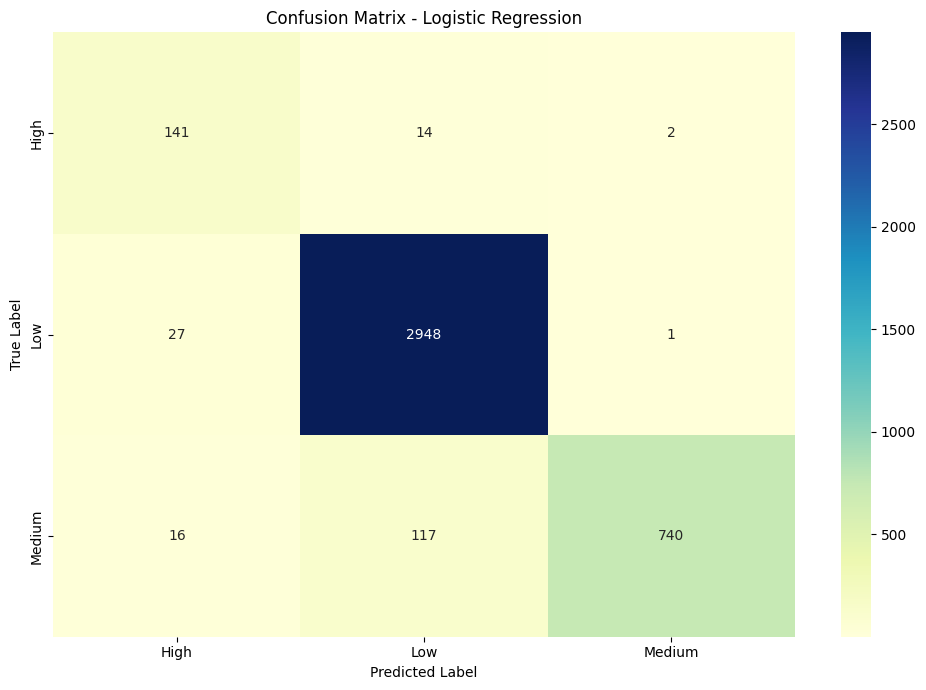


🚀 Evaluating: Random Forest
✅ Accuracy: 0.7039
              precision    recall  f1-score   support

        High       0.62      0.71      0.66       157
         Low       0.91      0.68      0.78      2976
      Medium       0.43      0.80      0.56       873

    accuracy                           0.70      4006
   macro avg       0.65      0.73      0.67      4006
weighted avg       0.80      0.70      0.72      4006



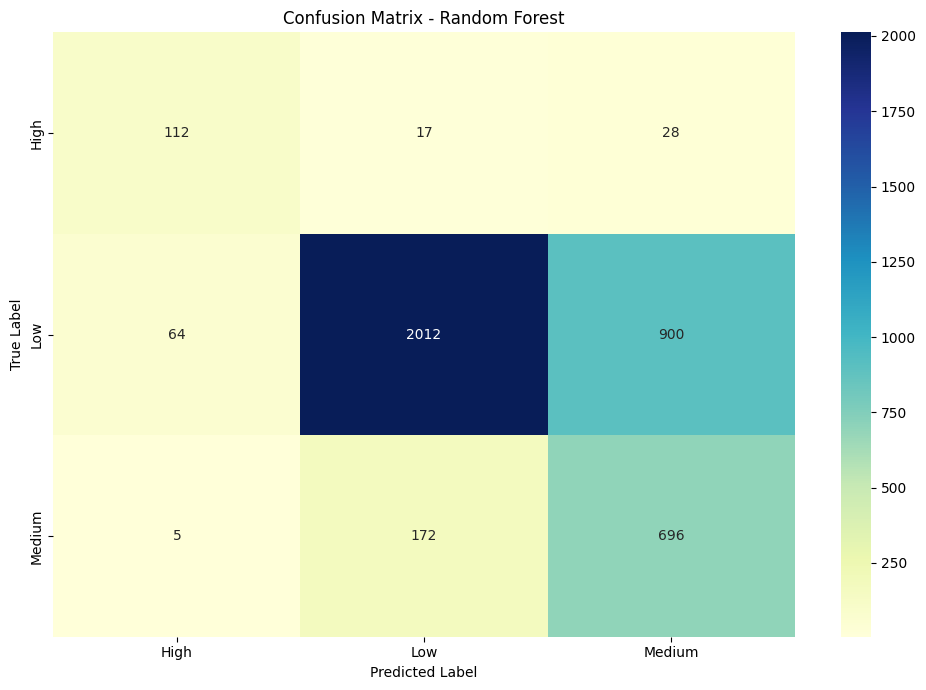


🚀 Evaluating: XGBoost
✅ Accuracy: 0.7259
              precision    recall  f1-score   support

        High       0.53      0.68      0.60       157
         Low       0.92      0.71      0.80      2976
      Medium       0.46      0.80      0.58       873

    accuracy                           0.73      4006
   macro avg       0.64      0.73      0.66      4006
weighted avg       0.81      0.73      0.74      4006



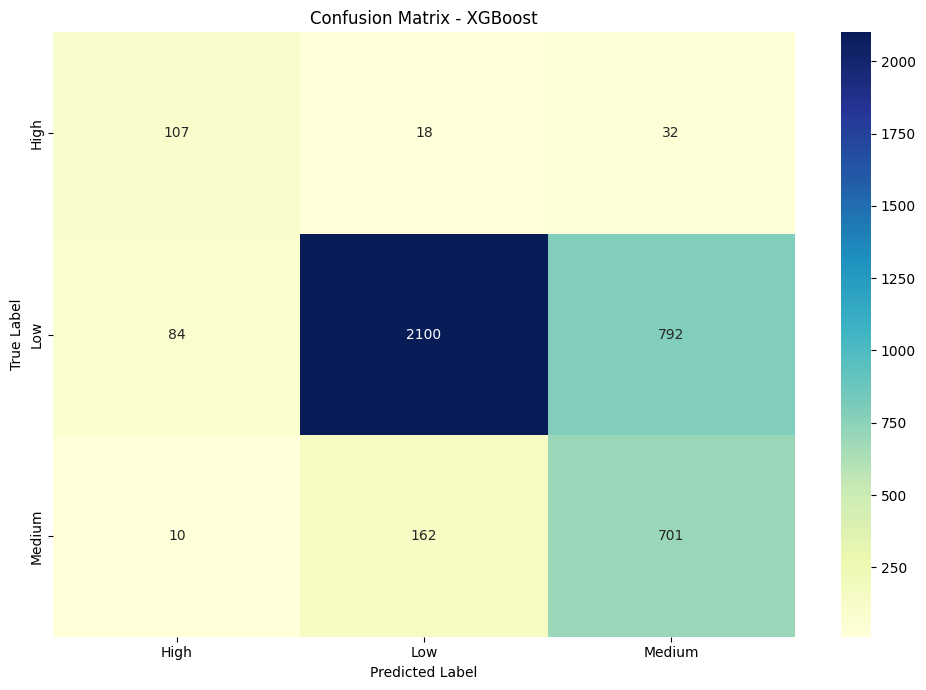


🚀 Evaluating: Naive Bayes
✅ Accuracy: 0.7808
              precision    recall  f1-score   support

        High       0.79      0.66      0.72       157
         Low       0.88      0.83      0.85      2976
      Medium       0.52      0.63      0.57       873

    accuracy                           0.78      4006
   macro avg       0.73      0.71      0.71      4006
weighted avg       0.80      0.78      0.79      4006



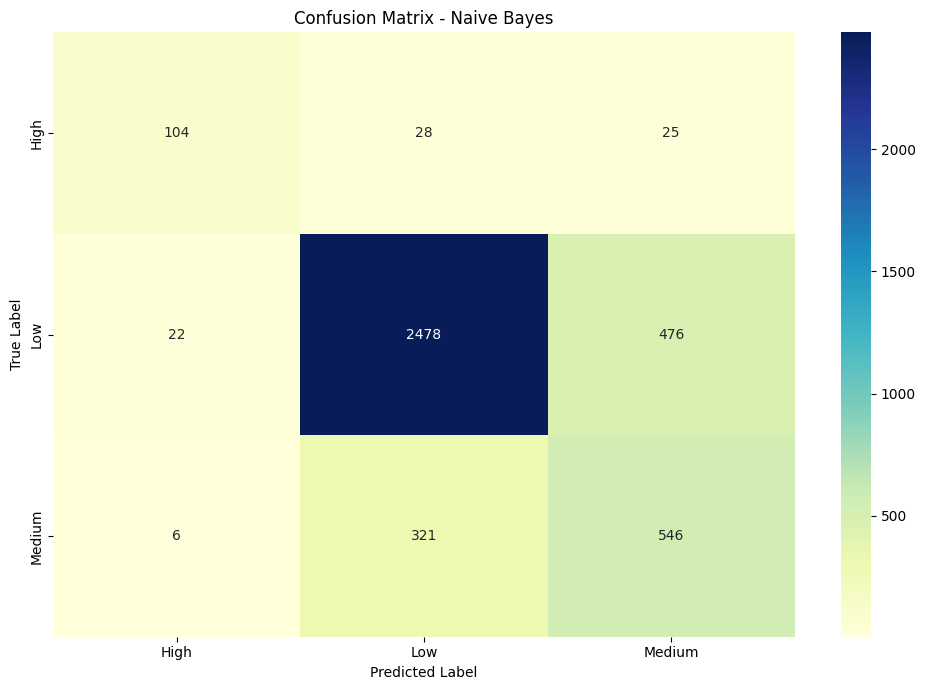


🚀 Evaluating: Hybrid
✅ Accuracy: 0.8947
              precision    recall  f1-score   support

        High       0.71      0.78      0.75       157
         Low       0.95      0.92      0.93      2976
      Medium       0.77      0.83      0.80       873

    accuracy                           0.89      4006
   macro avg       0.81      0.84      0.83      4006
weighted avg       0.90      0.89      0.90      4006



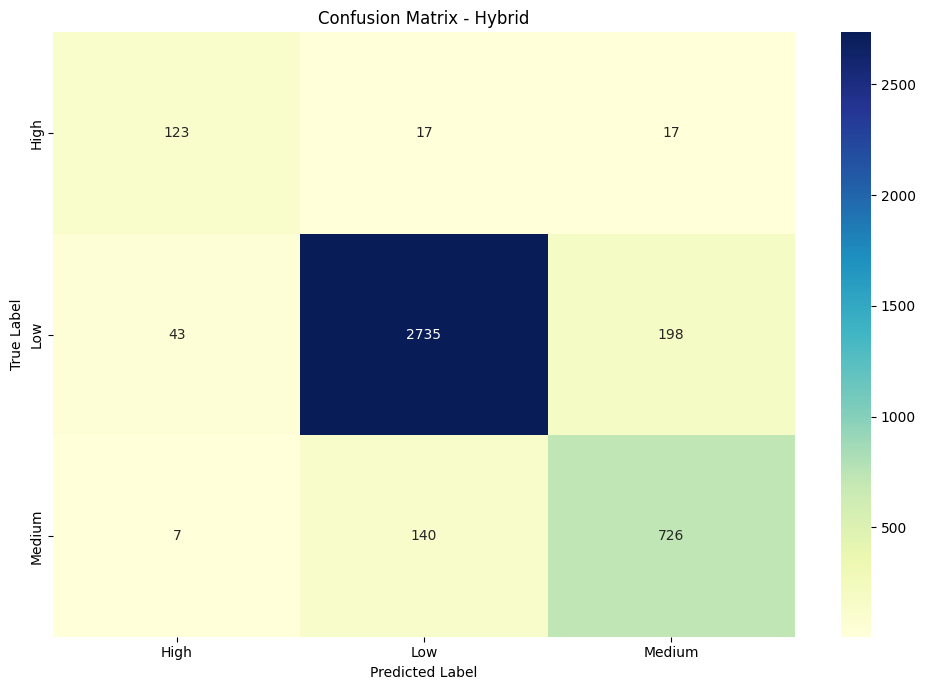


📊 Model Comparison Summary:
                 Model  Accuracy  Precision    Recall  F1-Score
1  Logistic Regression  0.955816   0.906573  0.912111  0.905521
5               Hybrid  0.894658   0.809405  0.844691  0.826023
0                  SVM  0.877683   0.798336  0.791720  0.785640
4          Naive Bayes  0.780829   0.728639  0.706837  0.714171
3              XGBoost  0.725911   0.637688  0.730051  0.660502
2        Random Forest  0.703944   0.653829  0.728901  0.665825


C:\Users\User\AppData\Local\Temp\ipykernel_3536\3316641677.py:90: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=comparison_df, x="Accuracy", y="Model", palette="viridis")
C:\Users\User\AppData\Local\Temp\ipykernel_3536\3316641677.py:94: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


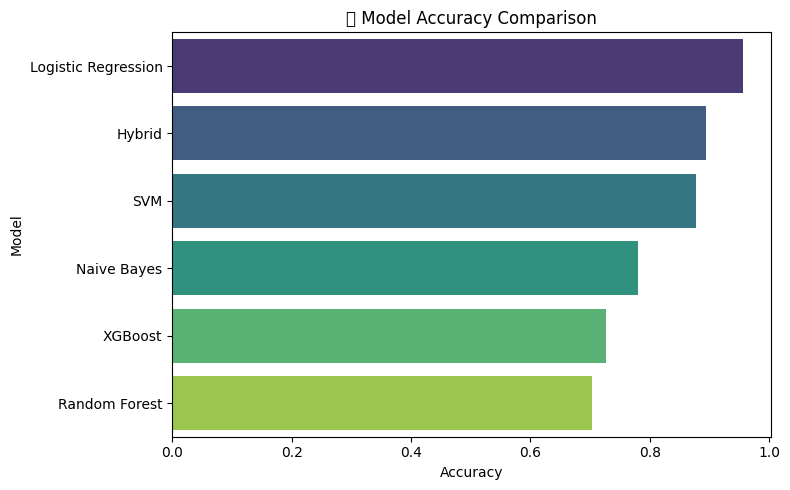

In [1]:
import pandas as pd
import joblib
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import os

# === Step 1: Load test data ===
test_data_path = r"C:/Users/User/OneDrive - Asia Pacific University/APU Final Year Project/FYP Email Project Documents/Email Dataset Python/Model Building/Prioritization/real_world_priority_email_with_priority.csv"
df_test = pd.read_csv(test_data_path)

# === Step 2: Load label encoder and BERT embedder ===
save_dir = r"C:/Users/User/OneDrive - Asia Pacific University/APU Final Year Project/FYP Email Project Documents/Email Dataset Python/Model Building/Prioritization/Test Bert Results"

encoder_path = os.path.join(save_dir, 'label_encoder.joblib')
embedder_path = os.path.join(save_dir, 'bert_embedder_model')

label_encoder = joblib.load(encoder_path)
embedder = SentenceTransformer(embedder_path)

# === Step 3: Preprocess and generate BERT embeddings ===
df_test['Combined_Text'] = df_test['Subject'].fillna('') + ' ' + df_test['Message'].fillna('')
X_test_text = df_test['Combined_Text'].astype(str).tolist()
X_test_embed = embedder.encode(X_test_text, show_progress_bar=True)

# === Step 4: Encode true labels if available ===
if 'True_Priority' in df_test.columns:
    y_true = label_encoder.transform(df_test['True_Priority'])

# === Step 5: Define All BERT-based Model Paths ===
model_paths = {
    "SVM": os.path.join(save_dir, 'bert_svm_model.joblib'),
    "Logistic Regression": os.path.join(save_dir, 'bert_lr_model.joblib'),
    "Random Forest": os.path.join(save_dir, 'bert_rf_model.joblib'),
    "XGBoost": os.path.join(save_dir, 'bert_xgb_model.joblib'),
    "Naive Bayes": os.path.join(save_dir, 'bert_nb_model.joblib'),
    "Hybrid": os.path.join(save_dir, 'bert_hybrid_soft_model.joblib')
}

# === Step 6: Evaluate All Models ===
comparison_results = []

for model_name, model_path in model_paths.items():
    print(f"\n🚀 Evaluating: {model_name}")
    model = joblib.load(model_path)
    y_pred = model.predict(X_test_embed)

    # ✅ Identify present classes in test set
    unique_labels = np.unique(y_true)
    target_names = label_encoder.inverse_transform(unique_labels)

    # ✅ Metrics
    acc = accuracy_score(y_true, y_pred)
    report_dict = classification_report(y_true, y_pred, labels=unique_labels, target_names=target_names, output_dict=True)

    # ✅ Append to summary
    comparison_results.append({
        "Model": model_name,
        "Accuracy": acc,
        "Precision": report_dict["macro avg"]["precision"],
        "Recall": report_dict["macro avg"]["recall"],
        "F1-Score": report_dict["macro avg"]["f1-score"]
    })

    # ✅ Print report
    print(f"✅ Accuracy: {acc:.4f}")
    print(classification_report(y_true, y_pred, labels=unique_labels, target_names=target_names))

    # ✅ Plot confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred, labels=unique_labels)
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt="d",
                xticklabels=target_names, yticklabels=target_names, cmap="YlGnBu")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.show()

# === Step 7: Compare All Models ===
comparison_df = pd.DataFrame(comparison_results).sort_values(by="Accuracy", ascending=False)

print("\n📊 Model Comparison Summary:")
print(comparison_df)

# === Step 8: Plot Comparison
plt.figure(figsize=(8, 5))
sns.barplot(data=comparison_df, x="Accuracy", y="Model", palette="viridis")
plt.title("📈 Model Accuracy Comparison")
plt.xlabel("Accuracy")
plt.ylabel("Model")
plt.tight_layout()
plt.show()

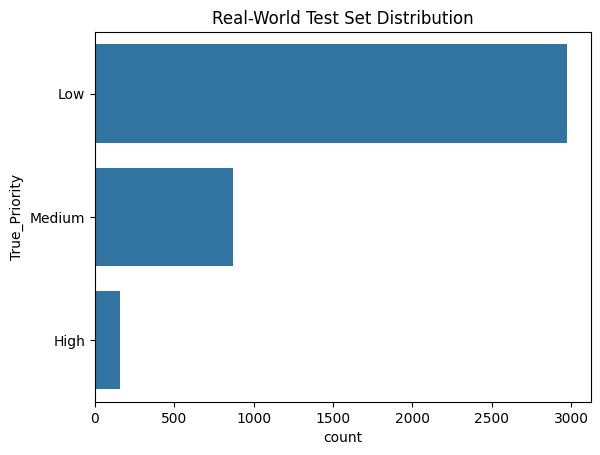

In [2]:
df_test['True_Priority'].value_counts()
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(y='True_Priority', data=df_test)
plt.title('Real-World Test Set Distribution')
plt.show()

# Kaggle + Synthetic dataset

Batches:   0%|          | 0/4635 [00:00<?, ?it/s]


🚀 Evaluating: SVM
✅ Accuracy: 0.6026
              precision    recall  f1-score   support

        High       0.72      0.80      0.76     49432
         Low       0.57      0.66      0.61     49432
      Medium       0.48      0.35      0.40     49432

    accuracy                           0.60    148296
   macro avg       0.59      0.60      0.59    148296
weighted avg       0.59      0.60      0.59    148296



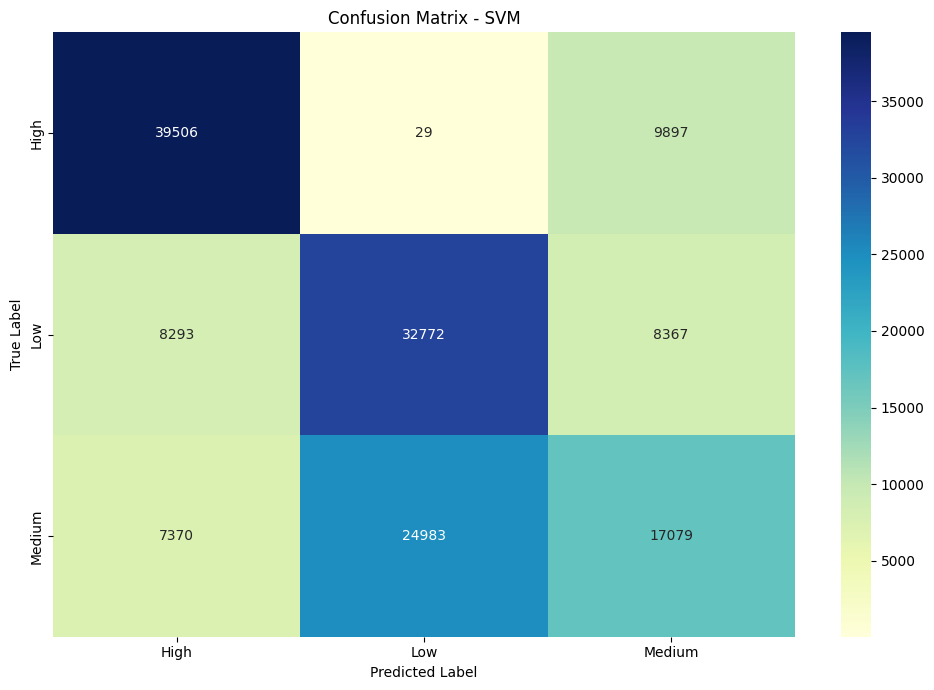


🚀 Evaluating: Logistic Regression
✅ Accuracy: 0.6507
              precision    recall  f1-score   support

        High       0.88      0.80      0.84     49432
         Low       0.59      0.81      0.68     49432
      Medium       0.48      0.34      0.40     49432

    accuracy                           0.65    148296
   macro avg       0.65      0.65      0.64    148296
weighted avg       0.65      0.65      0.64    148296



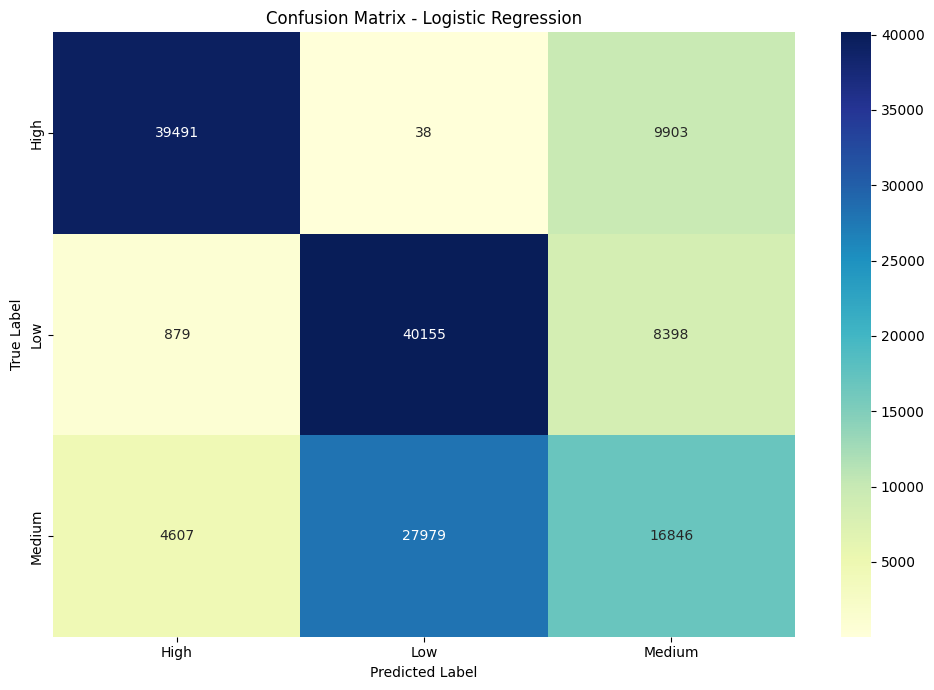


🚀 Evaluating: Random Forest
✅ Accuracy: 0.7256
              precision    recall  f1-score   support

        High       0.90      0.80      0.85     49432
         Low       0.69      0.83      0.76     49432
      Medium       0.60      0.55      0.57     49432

    accuracy                           0.73    148296
   macro avg       0.73      0.73      0.72    148296
weighted avg       0.73      0.73      0.72    148296



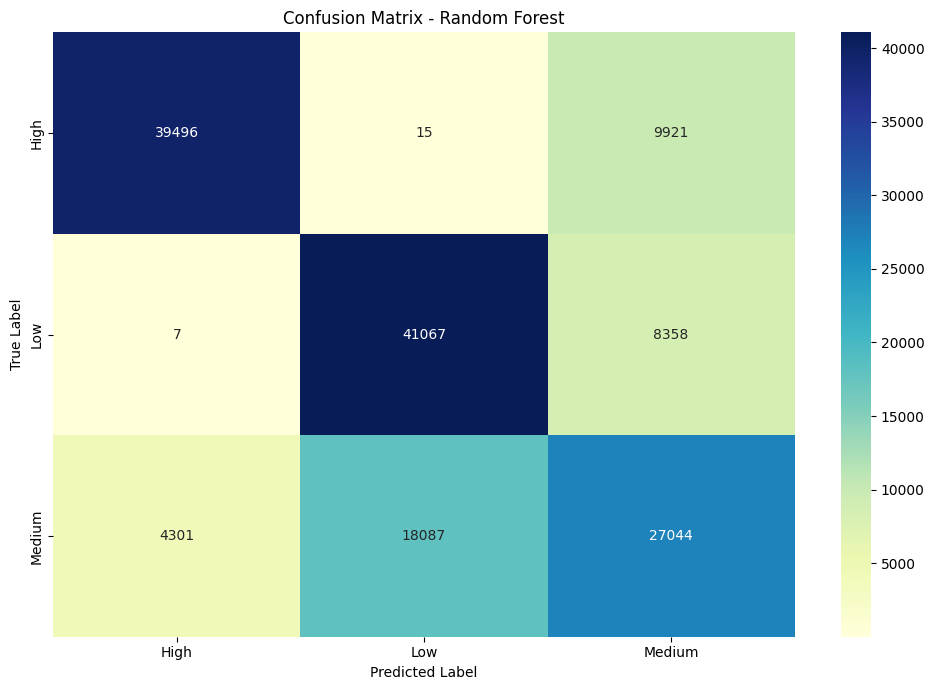


🚀 Evaluating: XGBoost
✅ Accuracy: 0.6957
              precision    recall  f1-score   support

        High       0.88      0.80      0.84     49432
         Low       0.66      0.83      0.73     49432
      Medium       0.55      0.46      0.50     49432

    accuracy                           0.70    148296
   macro avg       0.70      0.70      0.69    148296
weighted avg       0.70      0.70      0.69    148296



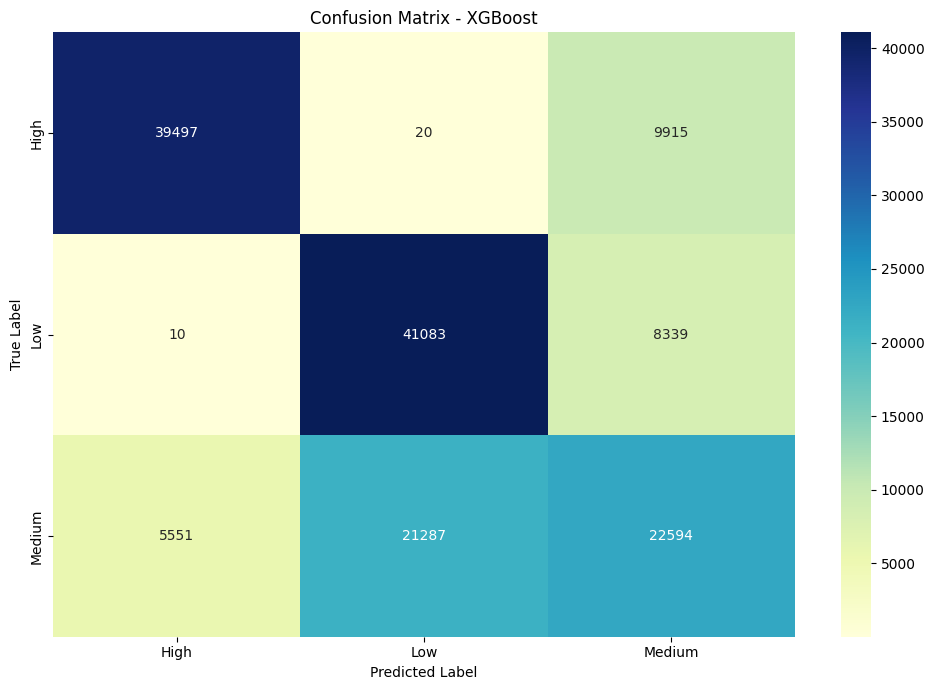


🚀 Evaluating: Naive Bayes
✅ Accuracy: 0.6959
              precision    recall  f1-score   support

        High       0.91      0.60      0.73     49432
         Low       0.69      0.98      0.81     49432
      Medium       0.55      0.51      0.53     49432

    accuracy                           0.70    148296
   macro avg       0.72      0.70      0.69    148296
weighted avg       0.72      0.70      0.69    148296



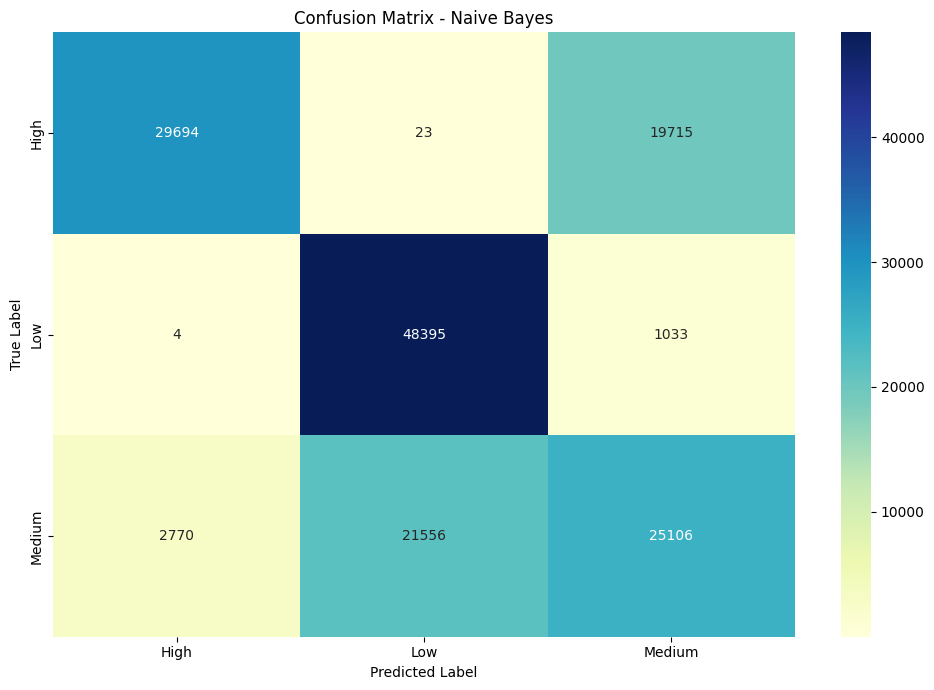


🚀 Evaluating: Hybrid
✅ Accuracy: 0.6269
              precision    recall  f1-score   support

        High       0.75      0.80      0.77     49432
         Low       0.58      0.66      0.62     49432
      Medium       0.53      0.42      0.47     49432

    accuracy                           0.63    148296
   macro avg       0.62      0.63      0.62    148296
weighted avg       0.62      0.63      0.62    148296



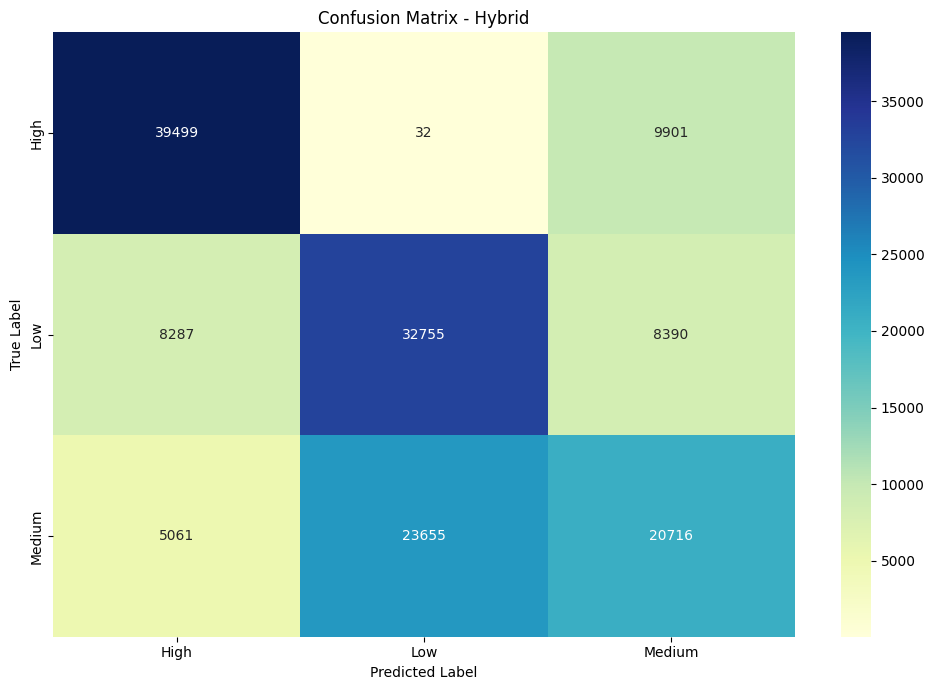


📊 Model Comparison Summary:
                 Model  Accuracy  Precision    Recall  F1-Score
2        Random Forest  0.725623   0.730803  0.725623  0.724779
4          Naive Bayes  0.695872   0.717899  0.695872  0.687562
3              XGBoost  0.695730   0.696064  0.695730  0.690443
1  Logistic Regression  0.650672   0.648784  0.650672  0.639276
5               Hybrid  0.626922   0.619612  0.626922  0.619871
0                  SVM  0.602558   0.588824  0.602558  0.589873


C:\Users\User\AppData\Local\Temp\ipykernel_10580\1109609679.py:90: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=comparison_df, x="Accuracy", y="Model", palette="viridis")
C:\Users\User\AppData\Local\Temp\ipykernel_10580\1109609679.py:94: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


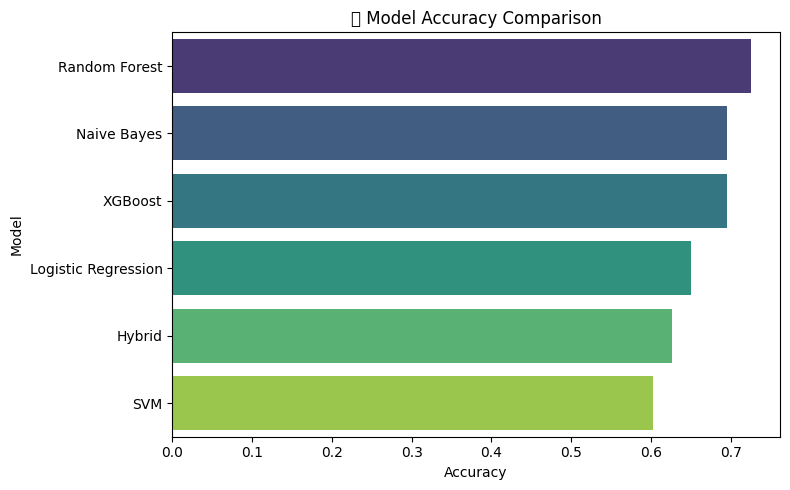

In [7]:
import pandas as pd
import joblib
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import os

# === Step 1: Load test data ===
test_data_path = r"C:/Users/User/OneDrive - Asia Pacific University/APU Final Year Project/FYP Email Project Documents/Email Dataset Python/Model Building/Prioritization/cleaned_priority_email_dataset.csv"
df_test = pd.read_csv(test_data_path)

# === Step 2: Load label encoder and BERT embedder ===
save_dir = r"C:/Users/User/OneDrive - Asia Pacific University/APU Final Year Project/FYP Email Project Documents/Email Dataset Python/Model Building/Prioritization/Test Bert Results"

encoder_path = os.path.join(save_dir, 'label_encoder.joblib')
embedder_path = os.path.join(save_dir, 'bert_embedder_model')

label_encoder = joblib.load(encoder_path)
embedder = SentenceTransformer(embedder_path)

# === Step 3: Preprocess and generate BERT embeddings ===
df_test['Combined_Text'] = df_test['Subject'].fillna('') + ' ' + df_test['Message'].fillna('')
X_test_text = df_test['Combined_Text'].astype(str).tolist()
X_test_embed = embedder.encode(X_test_text, show_progress_bar=True)

# === Step 4: Encode true labels if available ===
if 'True_Priority' in df_test.columns:
    y_true = label_encoder.transform(df_test['True_Priority'])

# === Step 5: Define All BERT-based Model Paths ===
model_paths = {
    "SVM": os.path.join(save_dir, 'bert_svm_model.joblib'),
    "Logistic Regression": os.path.join(save_dir, 'bert_lr_model.joblib'),
    "Random Forest": os.path.join(save_dir, 'bert_rf_model.joblib'),
    "XGBoost": os.path.join(save_dir, 'bert_xgb_model.joblib'),
    "Naive Bayes": os.path.join(save_dir, 'bert_nb_model.joblib'),
    "Hybrid": os.path.join(save_dir, 'bert_hybrid_soft_model.joblib')
}

# === Step 6: Evaluate All Models ===
comparison_results = []

for model_name, model_path in model_paths.items():
    print(f"\n🚀 Evaluating: {model_name}")
    model = joblib.load(model_path)
    y_pred = model.predict(X_test_embed)

    # ✅ Identify present classes in test set
    unique_labels = np.unique(y_true)
    target_names = label_encoder.inverse_transform(unique_labels)

    # ✅ Metrics
    acc = accuracy_score(y_true, y_pred)
    report_dict = classification_report(y_true, y_pred, labels=unique_labels, target_names=target_names, output_dict=True)

    # ✅ Append to summary
    comparison_results.append({
        "Model": model_name,
        "Accuracy": acc,
        "Precision": report_dict["macro avg"]["precision"],
        "Recall": report_dict["macro avg"]["recall"],
        "F1-Score": report_dict["macro avg"]["f1-score"]
    })

    # ✅ Print report
    print(f"✅ Accuracy: {acc:.4f}")
    print(classification_report(y_true, y_pred, labels=unique_labels, target_names=target_names))

    # ✅ Plot confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred, labels=unique_labels)
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt="d",
                xticklabels=target_names, yticklabels=target_names, cmap="YlGnBu")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.show()

# === Step 7: Compare All Models ===
comparison_df = pd.DataFrame(comparison_results).sort_values(by="Accuracy", ascending=False)

print("\n📊 Model Comparison Summary:")
print(comparison_df)

# === Step 8: Plot Comparison
plt.figure(figsize=(8, 5))
sns.barplot(data=comparison_df, x="Accuracy", y="Model", palette="viridis")
plt.title("📈 Model Accuracy Comparison")
plt.xlabel("Accuracy")
plt.ylabel("Model")
plt.tight_layout()
plt.show()

# Synthetic Dataset Low + High

Batches:   0%|          | 0/2444 [00:00<?, ?it/s]


🚀 Evaluating: SVM
✅ Accuracy: 0.8181
              precision    recall  f1-score   support

        High       0.96      0.96      0.96     39219
         Low       1.00      0.68      0.81     38977

   micro avg       0.98      0.82      0.89     78196
   macro avg       0.98      0.82      0.88     78196
weighted avg       0.98      0.82      0.88     78196



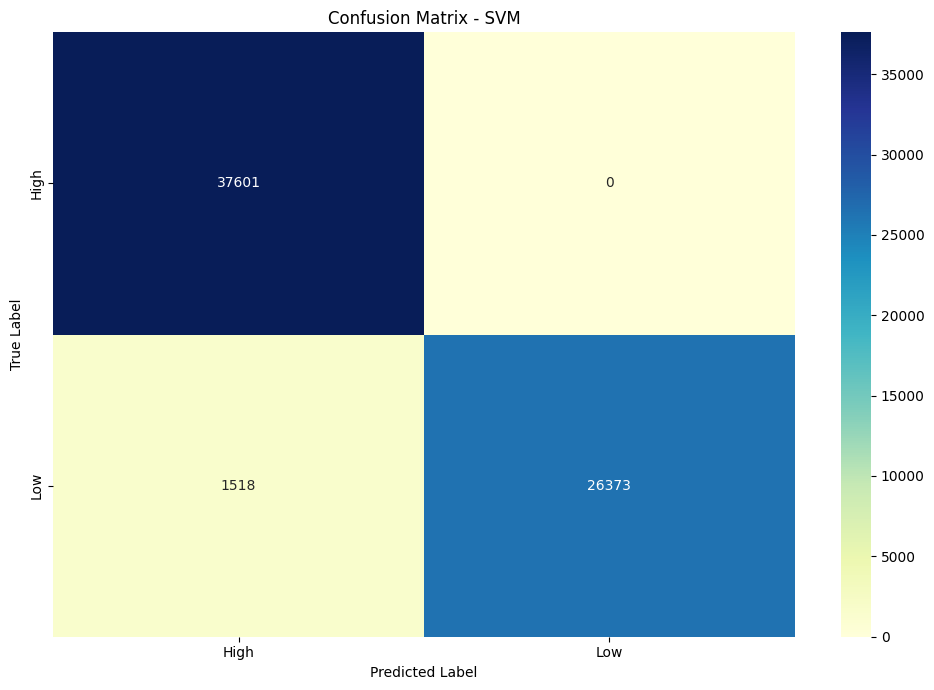


🚀 Evaluating: Logistic Regression
✅ Accuracy: 0.6567
              precision    recall  f1-score   support

        High       0.94      0.68      0.79     39219
         Low       1.00      0.63      0.78     38977

   micro avg       0.97      0.66      0.78     78196
   macro avg       0.97      0.66      0.78     78196
weighted avg       0.97      0.66      0.78     78196



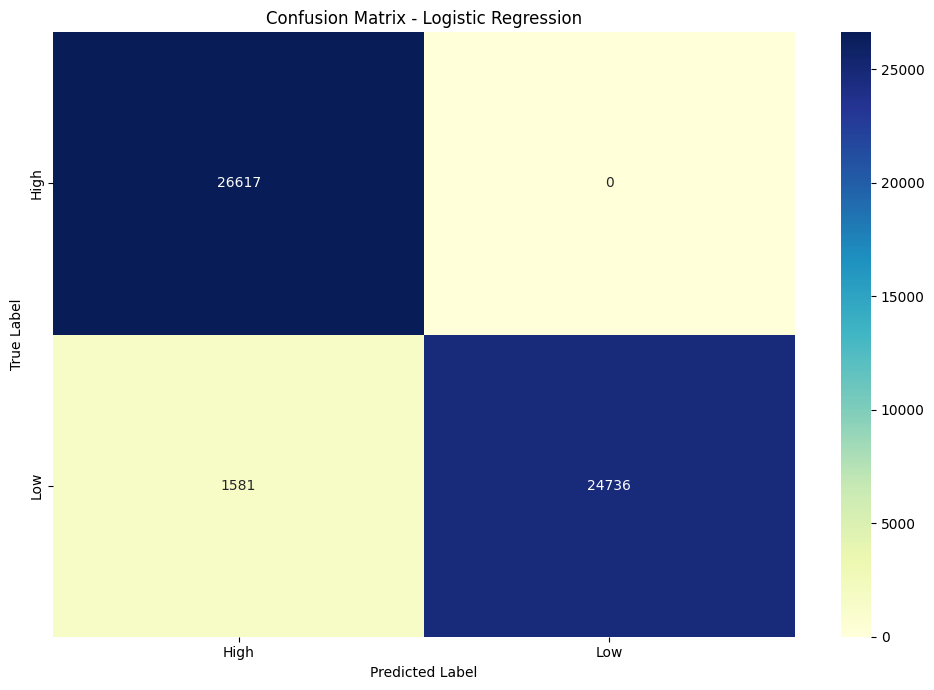


🚀 Evaluating: Random Forest
✅ Accuracy: 0.5581
              precision    recall  f1-score   support

        High       1.00      0.64      0.78     39219
         Low       1.00      0.48      0.65     38977

   micro avg       1.00      0.56      0.72     78196
   macro avg       1.00      0.56      0.71     78196
weighted avg       1.00      0.56      0.71     78196



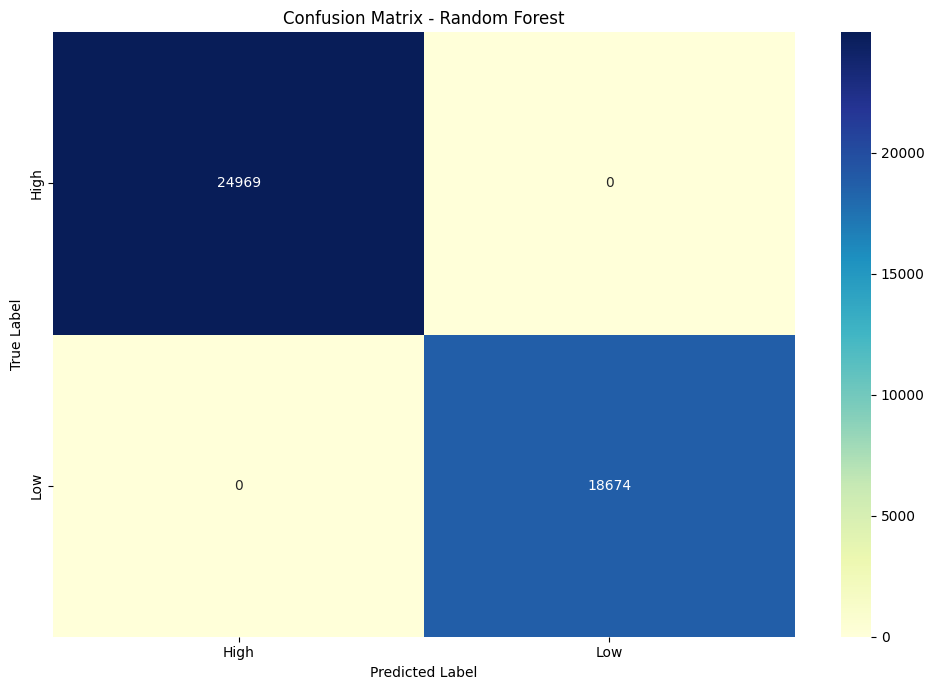


🚀 Evaluating: XGBoost
✅ Accuracy: 0.6175
              precision    recall  f1-score   support

        High       1.00      0.64      0.78     39219
         Low       0.94      0.60      0.73     38977

   micro avg       0.97      0.62      0.75     78196
   macro avg       0.97      0.62      0.75     78196
weighted avg       0.97      0.62      0.75     78196



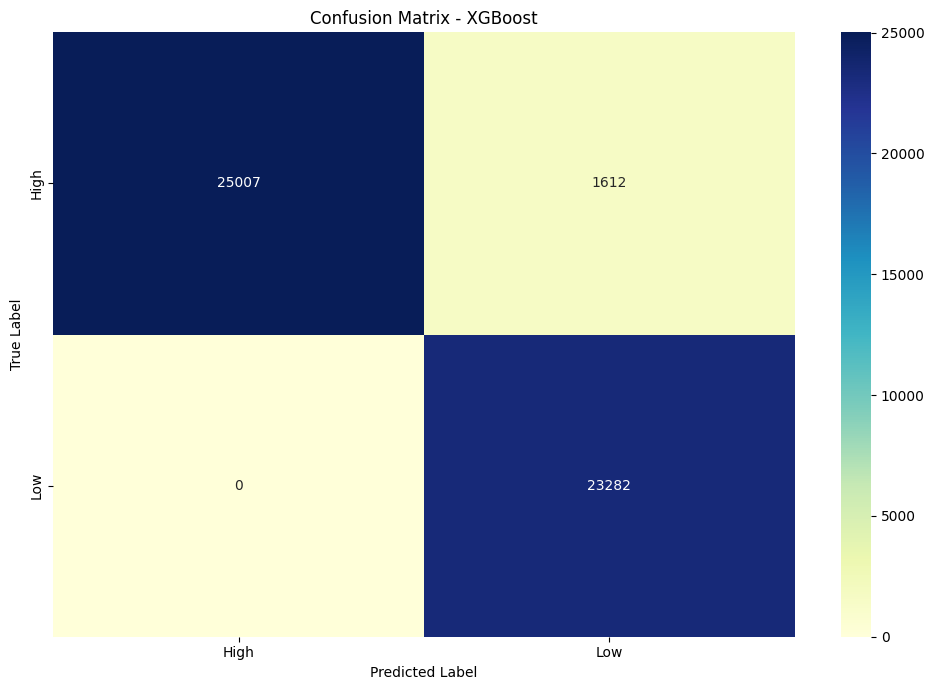


🚀 Evaluating: Naive Bayes
✅ Accuracy: 0.4776
              precision    recall  f1-score   support

        High       1.00      0.48      0.65     39219
         Low       1.00      0.48      0.65     38977

   micro avg       1.00      0.48      0.65     78196
   macro avg       1.00      0.48      0.65     78196
weighted avg       1.00      0.48      0.65     78196



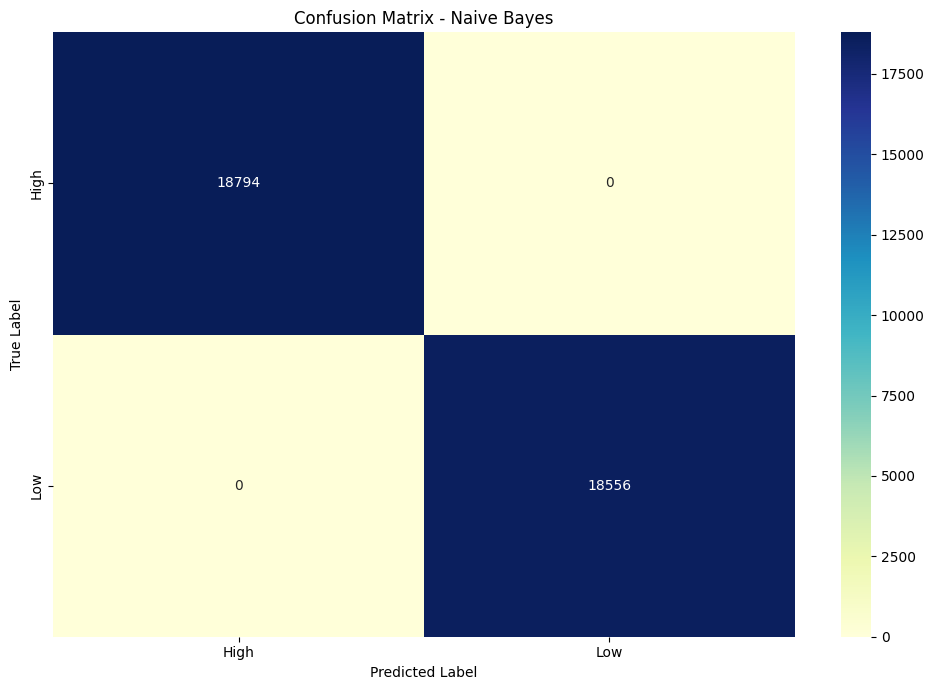


🚀 Evaluating: Hybrid
✅ Accuracy: 0.6379
              precision    recall  f1-score   support

        High       1.00      0.72      0.84     39219
         Low       1.00      0.56      0.71     38977

   micro avg       1.00      0.64      0.78     78196
   macro avg       1.00      0.64      0.78     78196
weighted avg       1.00      0.64      0.78     78196



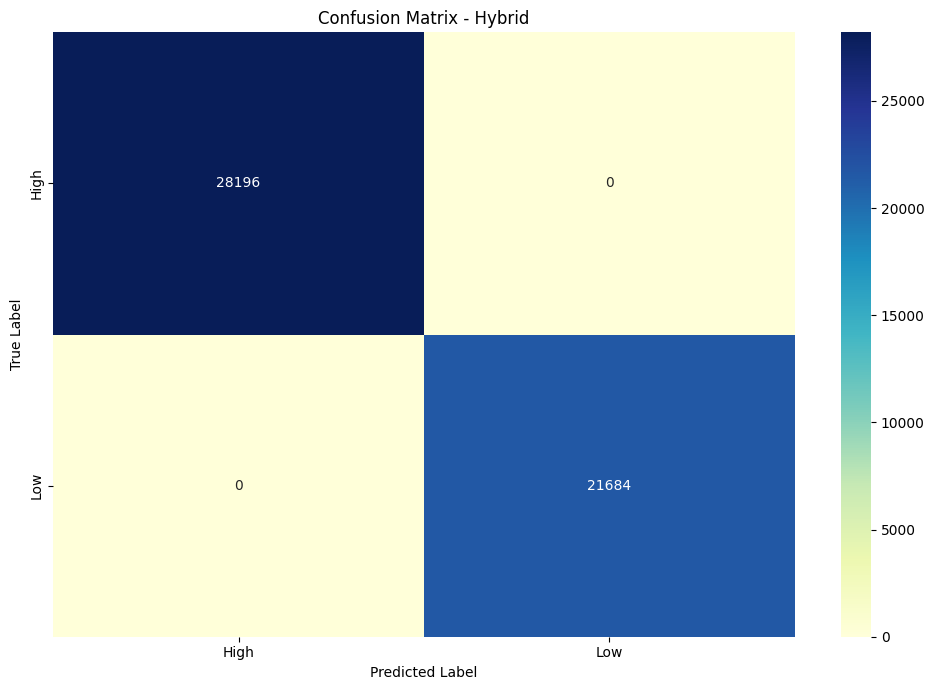


📊 Model Comparison Summary:
                 Model  Accuracy  Precision    Recall  F1-Score
0                  SVM  0.818124   0.980598  0.817687  0.883550
1  Logistic Regression  0.656722   0.971966  0.656653  0.783052
5               Hybrid  0.637884   1.000000  0.637633  0.775707
3              XGBoost  0.617538   0.967623  0.617476  0.753875
2        Random Forest  0.558123   1.000000  0.557879  0.712913
4          Naive Bayes  0.477646   1.000000  0.477641  0.646490


C:\Users\User\AppData\Local\Temp\ipykernel_10580\2685858483.py:90: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=comparison_df, x="Accuracy", y="Model", palette="viridis")
C:\Users\User\AppData\Local\Temp\ipykernel_10580\2685858483.py:94: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


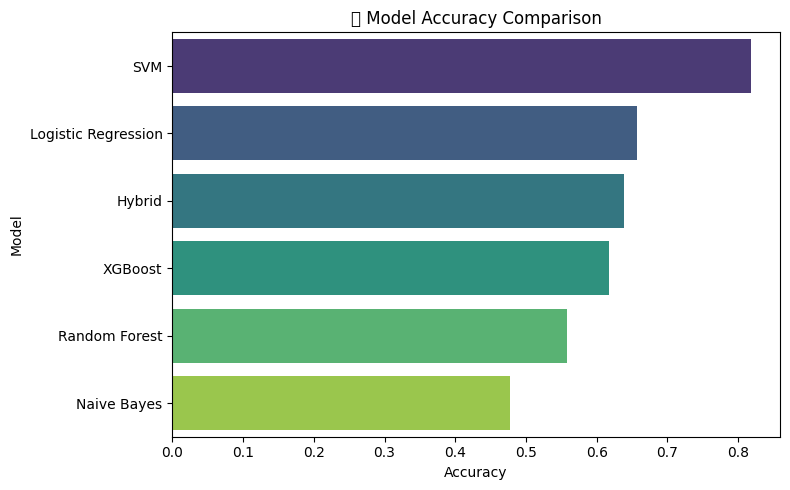

In [6]:
import pandas as pd
import joblib
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import os

# === Step 1: Load test data ===
test_data_path = r"C:/Users/User/OneDrive - Asia Pacific University/APU Final Year Project/FYP Email Project Documents/Email Dataset Python/Model Building/Prioritization/cleaned_priority_synthetic_balanced_full_dataset.csv"
df_test = pd.read_csv(test_data_path)

# === Step 2: Load label encoder and BERT embedder ===
save_dir = r"C:/Users/User/OneDrive - Asia Pacific University/APU Final Year Project/FYP Email Project Documents/Email Dataset Python/Model Building/Prioritization/Test Bert Results"

encoder_path = os.path.join(save_dir, 'label_encoder.joblib')
embedder_path = os.path.join(save_dir, 'bert_embedder_model')

label_encoder = joblib.load(encoder_path)
embedder = SentenceTransformer(embedder_path)

# === Step 3: Preprocess and generate BERT embeddings ===
df_test['Combined_Text'] = df_test['Subject'].fillna('') + ' ' + df_test['Message'].fillna('')
X_test_text = df_test['Combined_Text'].astype(str).tolist()
X_test_embed = embedder.encode(X_test_text, show_progress_bar=True)

# === Step 4: Encode true labels if available ===
if 'True_Priority' in df_test.columns:
    y_true = label_encoder.transform(df_test['True_Priority'])

# === Step 5: Define All BERT-based Model Paths ===
model_paths = {
    "SVM": os.path.join(save_dir, 'bert_svm_model.joblib'),
    "Logistic Regression": os.path.join(save_dir, 'bert_lr_model.joblib'),
    "Random Forest": os.path.join(save_dir, 'bert_rf_model.joblib'),
    "XGBoost": os.path.join(save_dir, 'bert_xgb_model.joblib'),
    "Naive Bayes": os.path.join(save_dir, 'bert_nb_model.joblib'),
    "Hybrid": os.path.join(save_dir, 'bert_hybrid_soft_model.joblib')
}

# === Step 6: Evaluate All Models ===
comparison_results = []

for model_name, model_path in model_paths.items():
    print(f"\n🚀 Evaluating: {model_name}")
    model = joblib.load(model_path)
    y_pred = model.predict(X_test_embed)

    # ✅ Identify present classes in test set
    unique_labels = np.unique(y_true)
    target_names = label_encoder.inverse_transform(unique_labels)

    # ✅ Metrics
    acc = accuracy_score(y_true, y_pred)
    report_dict = classification_report(y_true, y_pred, labels=unique_labels, target_names=target_names, output_dict=True)

    # ✅ Append to summary
    comparison_results.append({
        "Model": model_name,
        "Accuracy": acc,
        "Precision": report_dict["macro avg"]["precision"],
        "Recall": report_dict["macro avg"]["recall"],
        "F1-Score": report_dict["macro avg"]["f1-score"]
    })

    # ✅ Print report
    print(f"✅ Accuracy: {acc:.4f}")
    print(classification_report(y_true, y_pred, labels=unique_labels, target_names=target_names))

    # ✅ Plot confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred, labels=unique_labels)
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt="d",
                xticklabels=target_names, yticklabels=target_names, cmap="YlGnBu")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.show()

# === Step 7: Compare All Models ===
comparison_df = pd.DataFrame(comparison_results).sort_values(by="Accuracy", ascending=False)

print("\n📊 Model Comparison Summary:")
print(comparison_df)

# === Step 8: Plot Comparison
plt.figure(figsize=(8, 5))
sns.barplot(data=comparison_df, x="Accuracy", y="Model", palette="viridis")
plt.title("📈 Model Accuracy Comparison")
plt.xlabel("Accuracy")
plt.ylabel("Model")
plt.tight_layout()
plt.show()

# Test Real Email Without Priority Label

In [5]:
import pandas as pd
import joblib
import numpy as np
from sentence_transformers import SentenceTransformer
import os

# === Step 1: Load your real email data (no labels) ===
df_real = pd.read_csv(
    r"C:/Users/User/OneDrive - Asia Pacific University/APU Final Year Project/FYP Email Project Documents/Email Dataset Python/Model Building/Prioritization/real_world_test_data_no_priority.csv"
)

# Combine Subject and Message into one text input
df_real['Combined_Text'] = df_real['Subject'].fillna('') + ' ' + df_real['Message'].fillna('')
X_real_text = df_real['Combined_Text'].astype(str).tolist()

# === Step 2: Load model components ===
save_dir = r"C:/Users/User/OneDrive - Asia Pacific University/APU Final Year Project/FYP Email Project Documents/Email Dataset Python/Model Building/Prioritization/Test Bert Results"

# Load BERT embedder and label encoder
embedder = SentenceTransformer(os.path.join(save_dir, 'bert_embedder_model'))
label_encoder = joblib.load(os.path.join(save_dir, 'label_encoder.joblib'))

# Load the trained model (e.g., hybrid voting model)
model = joblib.load(os.path.join(save_dir, 'bert_lr_model.joblib'))

# === Step 3: Generate BERT embeddings ===
X_real_embed = embedder.encode(X_real_text, show_progress_bar=True)

# === Step 4: Predict categories and confidence scores ===
y_pred = model.predict(X_real_embed)
y_proba = model.predict_proba(X_real_embed)

# Assign top 1 prediction
df_real['Predicted_Priority'] = label_encoder.inverse_transform(y_pred)
df_real['Confidence'] = np.max(y_proba, axis=1)

# === Step 5: Get Top 3 predictions ===
top_3_indices = np.argsort(-y_proba, axis=1)[:, :3]

# ✅ Apply inverse_transform row-wise for 2D array
top_3_labels = np.array([
    label_encoder.inverse_transform(row)
    for row in top_3_indices
])
top_3_confidence = np.take_along_axis(y_proba, top_3_indices, axis=1)

# Add top 3 predictions to dataframe
df_real['Top_1'] = top_3_labels[:, 0]
df_real['Top_2'] = top_3_labels[:, 1]
df_real['Top_3'] = top_3_labels[:, 2]
df_real['Top_1_Score'] = top_3_confidence[:, 0]
df_real['Top_2_Score'] = top_3_confidence[:, 1]
df_real['Top_3_Score'] = top_3_confidence[:, 2]

# === Step 6: Show prediction preview ===
print(df_real[['Subject', 'Predicted_Priority', 'Confidence', 'Top_1', 'Top_2', 'Top_3']].head())

# === Step 7: Save the result to CSV ===
output_path = os.path.join(save_dir, "real_priority_email_predictions_checking.csv")
df_real.to_csv(output_path, index=False)
print(f"\n✅ Predictions saved to:\n{output_path}")

Batches:   0%|          | 0/126 [00:00<?, ?it/s]

                                             Subject Predicted_Priority  \
0                             You have 1 new message                Low   
1                             You have 1 new message                Low   
2  E-Discovery made easy with Export Emails to Sh...                Low   
3  Instant resume insights with Export Emails to ...             Medium   
4  ⏰ Don’t miss your new limited-time opportuniti...                Low   

   Confidence   Top_1   Top_2   Top_3  
0    0.977472     Low    High  Medium  
1    0.977472     Low    High  Medium  
2    0.543357     Low  Medium    High  
3    0.524261  Medium     Low    High  
4    0.987239     Low  Medium    High  

✅ Predictions saved to:
C:/Users/User/OneDrive - Asia Pacific University/APU Final Year Project/FYP Email Project Documents/Email Dataset Python/Model Building/Prioritization/Test Bert Results\real_priority_email_predictions_checking.csv
